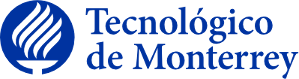

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 3: Avance 1 - Análisis Exploratorio de Datos

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Tabla de contenido
[Introducción](#intro)

1. [Descripción de las fuentes de datos](#fuentes)
2. [Carga de librerías y configuración inicial](#config)
3. [Carga y exploración inicial de los datos](#carga)
4. [Filtrado y limpieza de datos](#filtro)
5. [Homologación del nivel de agregación](#homologacion)
6. [Evaluación de la integración de información por variedad](#variedad)
7. [Desagregación temporal de la oferta productiva](#desagregacion)
8. [Exportación de conjuntos de datos](#exportacion)
9. [Análisis exploratorio de datos (EDA)](#eda)

[Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

El presente *notebook* tiene como objetivo realizar un **análisis exploratorio de datos (EDA)** como etapa inicial del proyecto de modelado predictivo de la oferta productiva de aguacate. En esta fase se busca comprender la estructura, calidad y consistencia de los datos disponibles, así como identificar patrones generales, valores atípicos y posibles limitaciones que puedan influir en las etapas posteriores de modelado.

Dado que la **información encontrada** proviene de múltiples fuentes del SIAP, una de las primeras tareas consiste en la unificación y preparación de los datos, incluyendo la selección del cultivo y entidad de interés, la eliminación de información no relevante y la homologación de los niveles de agregación. En particular, se integrarán datos provenientes de archivos del Anuario Estadístico[[1](#ref1)] y de Datos Abiertos[[2](#ref2)], considerando variables productivas como volumen, modalidad de producción, superficie sembrada, cosechada y siniestrada, con el fin de construir un conjunto de datos consistente para el análisis.

### <a class="anchor" id="fuentes">1. Descripción de las fuentes de datos</a>

Las fuentes de datos utilizadas en este análisis corresponden a información oficial publicada por el Servicio de Información Agroalimentaria y Pesquera (SIAP), y se describen a continuación:

* **Datos Abiertos SIAP – Nivel Estado (1980–2002)**
  Conjunto de archivos anuales en formato CSV que contienen información agrícola agregada a nivel estatal, incluyendo variables productivas como superficie sembrada, superficie cosechada, volumen de producción y modalidad de producción (Riego y Temporal). Estos archivos incluyen múltiples cultivos y entidades federativas, por lo que será necesario filtrar la información correspondiente al cultivo de aguacate en el estado de Jalisco.

* **Datos Abiertos SIAP – Nivel Municipio (2003–2024)**
  Conjunto de archivos anuales en formato CSV con información desagregada a nivel municipal. Además de las variables productivas, estos archivos incluyen identificadores administrativos adicionales que no son relevantes para el alcance del proyecto. Para mantener la consistencia temporal y geográfica del análisis, esta información será agregada a nivel estatal, conservando la distinción por modalidad de producción.

* **Anuario Estadístico SIAP (1980–2024)**
  Archivo consolidado que presenta información histórica del cultivo de aguacate a nivel estatal, incluyendo variables productivas y características adicionales como la variedad del cultivo. Esta fuente se utilizará principalmente para complementar el análisis mediante información por variedad y para contextualizar la evolución productiva del cultivo a lo largo del tiempo. **`NOTA`**: la recopilación de esta información fue manual, año por año desde el sitio del Anuario Estadístico del SIAP.[[1](#ref1)]
* **Indicador de comercio exterior – Importaciones mensuales de aguacate a Estados Unidos (1996–2024)**
  Conjunto de datos de frecuencia mensual provenientes del sistema de la U.S. International Trade Commission (USITC), que reporta los volúmenes de importación de aguacate por país de origen, utilizados en este proyecto como indicador auxiliar para capturar la distribución temporal intra–anual de la oferta productiva.[[3](#ref3)]

### <a class="anchor" id="config">2. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [1]:
# Cargar librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

SIAP_ABIERTOS_ESTADO_DIR = RAW_DATA_DIR / "siap_abiertos_estado"
SIAP_ABIERTOS_MUNICIPIO_DIR = RAW_DATA_DIR / "siap_abiertos_municipio"
SIAP_ANUARIO_FILE = RAW_DATA_DIR / "siap_anuario" / "anuario_aguacate.csv"

### <a class="anchor" id="carga">3. Carga y exploración inicial de los datos</a>

En esta sección se realiza una primera carga de las distintas fuentes de datos con el objetivo de entender su estructura, identificar las variables disponibles y validar la granularidad temporal y geográfica antes de aplicar cualquier proceso de limpieza o agregación.

#### 3.1 Datos Abiertos SIAP – Nivel Estado (1980–2002)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] que contienen información agrícola agregada a nivel estatal para el periodo 1980–2002. Cada archivo representa un año e incluye múltiples cultivos y entidades federativas.

In [4]:
# Listar archivos disponibles (nivel estado)
estado_files = sorted(SIAP_ABIERTOS_ESTADO_DIR.glob("*.csv"))

len(estado_files), estado_files[:5]

(23,
 [PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1980.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1981.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1982.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1983.csv'),
  PosixPath('data/raw/siap_abiertos_estado/Cierre_agricola_1984.csv')])

In [5]:
# Cargar y concatenar todos los archivos de nivel estado
df_estado_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in estado_files),
    ignore_index=True
)

df_estado_raw.shape

(70469, 19)

In [6]:
# Mostrar las primeras filas del DataFrame
df_estado_raw.head()

,Anio,Idestado,Nomestado,Idciclo,Nomcicloproductivo,Idmodalidad,Nommodalidad,Idunidadmedida,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion,Unnamed: 18
0,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,070,000.00",Ajo,"1,031.00","1,031.00",0.00,"8,926.00",8.66,7.00,"62,482.00",NaN
1,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,490,000.00",Avena forrajera en verde,715.00,711.00,4.00,"10,757.00",15.13,0.56,"5,981.00",NaN
2,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,670,000.00",Brócoli,30.00,30.00,0.00,200.00,6.67,4.00,800.00,NaN
3,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,740,000.00",Calabacita,9.00,9.00,0.00,45.00,5.00,4.00,180.00,NaN
4,"1,980.00",1.00,Aguascalientes,1.00,Otoño-Invierno,1.00,Riego,"200,201.00",Tonelada,"5,900,000.00",Cebada forrajera en verde,17.00,17.00,0.00,223.00,13.12,0.55,123.00,NaN


In [7]:
# Mostrar información del DataFrame
df_estado_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 70469 entries, 0 to 70468
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                70468 non-null  float64
 1   Idestado            70468 non-null  float64
 2   Nomestado           70468 non-null  str    
 3   Idciclo             70468 non-null  float64
 4   Nomcicloproductivo  70468 non-null  str    
 5   Idmodalidad         70468 non-null  float64
 6   Nommodalidad        70468 non-null  str    
 7   Idunidadmedida      70468 non-null  float64
 8   Nomunidad           70468 non-null  str    
 9   Idcultivo           70468 non-null  float64
 10  Nomcultivo          70468 non-null  str    
 11  Sembrada            70468 non-null  float64
 12  Cosechada           70468 non-null  float64
 13  Siniestrada         70468 non-null  float64
 14  Volumenproduccion   70468 non-null  float64
 15  Rendimiento         70468 non-null  float64
 16  Precio         

#####  **`NOTA`**
- Podemos notar que existe una columna basura (`Unnamed: 18`). Después de una inspección visual, se encontraron comas al final de las líneas del archivo del año 2001. Es seguro eliminar esa columna

In [8]:
# Eliminar columnas no nombradas
df_estado_raw = df_estado_raw.loc[:, ~df_estado_raw.columns.str.contains("^Unnamed")]

# Mostrar información del DataFrame
df_estado_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 70469 entries, 0 to 70468
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                70468 non-null  float64
 1   Idestado            70468 non-null  float64
 2   Nomestado           70468 non-null  str    
 3   Idciclo             70468 non-null  float64
 4   Nomcicloproductivo  70468 non-null  str    
 5   Idmodalidad         70468 non-null  float64
 6   Nommodalidad        70468 non-null  str    
 7   Idunidadmedida      70468 non-null  float64
 8   Nomunidad           70468 non-null  str    
 9   Idcultivo           70468 non-null  float64
 10  Nomcultivo          70468 non-null  str    
 11  Sembrada            70468 non-null  float64
 12  Cosechada           70468 non-null  float64
 13  Siniestrada         70468 non-null  float64
 14  Volumenproduccion   70468 non-null  float64
 15  Rendimiento         70468 non-null  float64
 16  Precio         

In [9]:
# Cultivos disponibles
df_estado_raw[
    df_estado_raw["Nomcultivo"].str.startswith("A", na=False)
]["Nomcultivo"].value_counts().head(10)

Nomcultivo
Avena forrajera en verde    1411
Aguacate                     981
Arroz palay                  701
Ajo                          642
Alfalfa verde                605
Ajonjolí                     581
Avena grano                  498
Algodón hueso                328
Acelga                       283
Alpiste                      272
Name: count, dtype: int64

In [10]:
# Estados disponibles
df_estado_raw["Nomestado"].value_counts().head(10)

Nomestado
Puebla             4138
Michoacán          4015
Jalisco            4012
México             3806
Oaxaca             2967
Guanajuato         2908
Baja California    2851
Veracruz           2817
Nayarit            2775
Guerrero           2617
Name: count, dtype: int64

In [11]:
# Modalidades de producción
df_estado_raw["Nommodalidad"].value_counts()

Nommodalidad
Riego       45069
Temporal    25399
Name: count, dtype: int64

#### 3.2 Datos Abiertos SIAP – Nivel Municipio (2003–2024)

Esta subsección corresponde a los archivos de Datos Abiertos del SIAP[[2](#ref2)] con información desagregada a nivel municipal para el periodo 2003–2024. Estos archivos incluyen identificadores administrativos adicionales que permiten mayor detalle geográfico, pero que deberán ser agregados para mantener la consistencia con los datos históricos.

In [12]:
# Listar archivos disponibles (nivel municipio)
municipio_files = sorted(SIAP_ABIERTOS_MUNICIPIO_DIR.glob("*.csv"))

len(municipio_files), municipio_files[:5]

(22,
 [PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2003.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2004.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2005.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2006.csv'),
  PosixPath('data/raw/siap_abiertos_municipio/Cierre_agricola_mun_2007.csv')])

In [13]:
df_municipio_raw = pd.concat(
    (pd.read_csv(f, encoding="latin-1") for f in municipio_files),
    ignore_index=True
)

df_municipio_raw.shape

/Users/juan.lopez/tmp/ipykernel_11058/505498559.py:2: DtypeWarning: Columns (0: Rendimiento) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, encoding="latin-1") for f in municipio_files),
/Users/juan.lopez/tmp/ipykernel_11058/505498559.py:2: DtypeWarning: Columns (0: Volumenproduccion) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, encoding="latin-1") for f in municipio_files),


(793769, 26)

#####  **`NOTA`**
Durante la exploración inicial se identificaron valores no numéricos y formatos inconsistentes en algunas variables productivas, los cuales fueron estandarizados y convertidos a valores numéricos o nulos según correspondiera, previo a la agregación de la información.

In [14]:
# Filtrar valores no convertibles a número en Volumenproduccion
volumen_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Volumenproduccion"], errors="coerce").isna()
    & df_municipio_raw["Volumenproduccion"].notna()
]["Volumenproduccion"]

volumen_no_numerico.value_counts().head(10)

Volumenproduccion
3,350.00    1
Name: count, dtype: int64

In [15]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Volumenproduccion"] = (
    df_municipio_raw["Volumenproduccion"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Volumenproduccion"] = pd.to_numeric(
    df_municipio_raw["Volumenproduccion"], errors="coerce"
)

In [16]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Volumenproduccion"].dtype

dtype('float64')

In [17]:
# Filtrar valores no convertibles a número en Rendimiento
rendimiento_no_numerico = df_municipio_raw[
    pd.to_numeric(df_municipio_raw["Rendimiento"], errors="coerce").isna()
    & df_municipio_raw["Rendimiento"].notna()
]["Rendimiento"]

rendimiento_no_numerico.value_counts().head(10)

Rendimiento
#¡NUM!    2
Name: count, dtype: int64

In [18]:
# Reemplazar valores no numéricos específicos en Rendimiento
df_municipio_raw["Rendimiento"] = (
    df_municipio_raw["Rendimiento"]
    .replace("#¡NUM!", np.nan)
)

df_municipio_raw["Rendimiento"] = pd.to_numeric(
    df_municipio_raw["Rendimiento"], errors="coerce"
)

In [19]:
# Verificar valores nulos después de la conversión
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].isna().sum()

Volumenproduccion      0
Rendimiento          489
dtype: int64

In [20]:
# Verificar los tipos de datos finales
df_municipio_raw[["Volumenproduccion", "Rendimiento"]].dtypes

Volumenproduccion    float64
Rendimiento          float64
dtype: object

In [21]:
# Mostrar las primeras filas del DataFrame
df_municipio_raw.head()

,Anio,Idestado,Nomestado,Idddr,Nomddr,Idcader,Nomcader,Idmunicipio,Nommunicipio,Idciclo,Nomcicloproductivo,Idmodalidad,Nommodalidad,Idunidadmedida,Nomunidad,Idcultivo,Nomcultivo,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion,Nomcultivo Sin Um,Preciomediorural
0,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5490000,Avena forrajera en verde,"1,062.00","1,062.00",0.00,"28,529.00",26.86,323.40,"9,226,278.60",NaN,NaN
1,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5900000,Cebada forrajera en verde,2.00,2.00,0.00,54.00,27.00,250.00,"13,500.00",NaN,NaN
2,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,5980000,Centeno forrajero en verde,17.00,17.00,0.00,"1,020.00",60.00,350.00,"357,000.00",NaN,NaN
3,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,9090000,Triticale forrajero en verde,24.00,24.00,0.00,720.00,30.00,400.00,"288,000.00",NaN,NaN
4,2003,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,1,Otoño-Invierno,1,Riego,200201,Tonelada,15050000,Pastos y praderas,415.00,415.00,0.00,"25,830.00",62.24,314.90,"8,133,867.00",NaN,NaN


In [22]:
# Mostrar información del DataFrame
df_municipio_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 793769 entries, 0 to 793768
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Anio                793769 non-null  int64  
 1   Idestado            793769 non-null  int64  
 2   Nomestado           793769 non-null  str    
 3   Idddr               793769 non-null  int64  
 4   Nomddr              793769 non-null  str    
 5   Idcader             793769 non-null  int64  
 6   Nomcader            793769 non-null  str    
 7   Idmunicipio         793769 non-null  int64  
 8   Nommunicipio        793769 non-null  str    
 9   Idciclo             793769 non-null  int64  
 10  Nomcicloproductivo  793769 non-null  str    
 11  Idmodalidad         793769 non-null  int64  
 12  Nommodalidad        793769 non-null  str    
 13  Idunidadmedida      793769 non-null  int64  
 14  Nomunidad           793769 non-null  str    
 15  Idcultivo           793769 non-null  int64  


#####  **`NOTAS`**
- Después de las correcciones aplicadas a las variables productivas `Volumenproduccion` y `Rendimiento`, notamos que `Sembrada` se muestra como **object**. 
- Podemos notar que hay variantes de nombres en dos columnas:
  - **Precio** también aparece como **Preciomediorural**
  - **Nomcultivo** también aparece como **Nomcultivo Sin Um**

Por este motivo es necesario revisar lo que pasa con la variable `Sembrada` y necesitamos unificar las dos variables con nombres alternos.

In [23]:
# Mostrar las primeras filas de Sembrada
df_municipio_raw["Sembrada"].head(5)

0   1,062.00
1       2.00
2      17.00
3      24.00
4     415.00
Name: Sembrada, dtype: object

In [24]:
# Revisar valores no numéricos en Sembrada
pd.to_numeric(df_municipio_raw["Sembrada"], errors="coerce").isna().sum()

np.int64(2)

In [25]:
# Reemplazar comas y convertir a numérico
df_municipio_raw["Sembrada"] = (
    df_municipio_raw["Sembrada"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df_municipio_raw["Sembrada"] = pd.to_numeric(
    df_municipio_raw["Sembrada"], errors="coerce"
)

In [26]:
# Verificar el tipo de dato después de la conversión
df_municipio_raw["Sembrada"].dtype

dtype('float64')

In [27]:
# Renombrar columnas para ser consistentes
column_mapping = {
    "Nomcultivo Sin Um": "Nomcultivo",
    "Preciomediorural": "Precio"
}


# Función para normalizar columnas según el mapeo dado
def normalize_columns(df, column_mapping):
    df = df.copy()
    
    for old_col, new_col in column_mapping.items():
        if old_col in df.columns:
            if new_col in df.columns:
                df[new_col] = df[new_col].fillna(df[old_col])
            else:
                df = df.rename(columns={old_col: new_col})
            df = df.drop(columns=[old_col])
    
    return df

df_municipio_raw = normalize_columns(df_municipio_raw, column_mapping)

In [28]:
# Mostrar información del DataFrame después de las correcciones
df_municipio_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 793769 entries, 0 to 793768
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Anio                793769 non-null  int64  
 1   Idestado            793769 non-null  int64  
 2   Nomestado           793769 non-null  str    
 3   Idddr               793769 non-null  int64  
 4   Nomddr              793769 non-null  str    
 5   Idcader             793769 non-null  int64  
 6   Nomcader            793769 non-null  str    
 7   Idmunicipio         793769 non-null  int64  
 8   Nommunicipio        793769 non-null  str    
 9   Idciclo             793769 non-null  int64  
 10  Nomcicloproductivo  793769 non-null  str    
 11  Idmodalidad         793769 non-null  int64  
 12  Nommodalidad        793769 non-null  str    
 13  Idunidadmedida      793769 non-null  int64  
 14  Nomunidad           793769 non-null  str    
 15  Idcultivo           793769 non-null  int64  


In [29]:
# Número de municipios distintos
df_municipio_raw["Nommunicipio"].nunique()

2314

In [30]:
# Modalidades de producción
df_municipio_raw["Nommodalidad"].value_counts()

Nommodalidad
Riego       431053
Temporal    362716
Name: count, dtype: int64

#### 3.3 Anuario Estadístico SIAP

El Anuario Estadístico del SIAP[1](#ref1)] contiene información consolidada del cultivo de aguacate a nivel estatal para todo el periodo de análisis, incluyendo variables productivas y características adicionales como la variedad del cultivo.

In [31]:
# Cargar datos del anuario, usamos UTF-8-SIG para evitar problemas con BOM
df_anuario_raw = pd.read_csv(SIAP_ANUARIO_FILE, encoding="utf-8-sig") 

df_anuario_raw.shape

(68, 14)

In [32]:
# Mostrar las primeras filas del DataFrame
df_anuario_raw.head()

,Anio,Nomcultivo,Variedad,Nomunidad,TipoTecnologia,TipoProduccion,TipoMercado,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Rendimiento,Precio,Valorproduccion
0,1980,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,250.00","2,885.00",0,"28,377.00",9.84,20,567.54
1,1981,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,121.00",0,"28,444.00",9.11,22.32,634.81
2,1982,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,131.00",0,"29,018.00",9.27,25.03,726.23
3,1983,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"1,840.00","1,503.00",0,"11,765.00",7.83,31.5,370.6
4,1984,Aguacate,Aguacate s/clasificar,Tonelada,Cielo abierto,Convencional,Nacional,"3,190.00","3,131.00",0,"24,155.00",7.71,79.82,"1,928.05"


In [33]:
# Mostrar información del DataFrame
df_anuario_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               68 non-null     int64  
 1   Nomcultivo         68 non-null     str    
 2   Variedad           68 non-null     str    
 3   Nomunidad          68 non-null     str    
 4   TipoTecnologia     68 non-null     str    
 5   TipoProduccion     68 non-null     str    
 6   TipoMercado        68 non-null     str    
 7   Sembrada           68 non-null     str    
 8   Cosechada          68 non-null     str    
 9   Siniestrada        68 non-null     int64  
 10  Volumenproduccion  68 non-null     str    
 11  Rendimiento        68 non-null     float64
 12  Precio             68 non-null     str    
 13  Valorproduccion    68 non-null     str    
dtypes: float64(1), int64(2), str(11)
memory usage: 7.6 KB


In [34]:
# Mostrar conteo de variedades
df_anuario_raw["Variedad"].value_counts()

Variedad
Aguacate s/clasificar    28
Aguacate criollo         20
Aguacate hass            20
Name: count, dtype: int64

### <a class="anchor" id="filtro">4. Filtrado y limpieza de datos</a>

A partir de esta etapa, el análisis se restringe exclusivamente al cultivo de aguacate en el estado de Jalisco. Este filtrado es fundamental para asegurar la coherencia del conjunto de datos con el alcance del proyecto y evitar sesgos derivados de la inclusión de información de otros cultivos o entidades federativas.

In [35]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel estado)
df_estado = df_estado_raw.copy()

df_estado = df_estado[
    (df_estado["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_estado["Nomestado"].str.upper() == "JALISCO")
]

df_estado.shape

(46, 18)

In [36]:
# Filtrar datos de aguacate en Jalisco (dataframe de datos a nivel municipio)
df_municipio = df_municipio_raw.copy()

df_municipio = df_municipio[
    (df_municipio["Nomcultivo"].str.upper() == "AGUACATE") &
    (df_municipio["Nomestado"].str.upper() == "JALISCO")
]

df_municipio.shape


(1731, 24)

In [37]:
# Filtrar datos de aguacate (dataframe de datos del anuario)
# NOTA: esto no es necesario porque el anuario solo tiene datos de aguacate, pero
#       se incluye el paso en caso de que el anuario contenga otros cultivos en el futuro
df_anuario = df_anuario_raw.copy()

df_anuario = df_anuario[
    df_anuario["Nomcultivo"].str.upper() == "AGUACATE"
]

df_anuario.shape

(68, 14)

In [38]:
# Eliminar columnas no relevantes en df_municipio
cols_no_relevantes = [
    "Idddr", "Nomddr",
    "Idcader", "Nomcader",
    "Idmunicipio", "Nommunicipio"
]

df_municipio = df_municipio.drop(columns=cols_no_relevantes)

df_municipio.info()

<class 'pandas.DataFrame'>
Index: 1731 entries, 9430 to 765899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anio                1731 non-null   int64  
 1   Idestado            1731 non-null   int64  
 2   Nomestado           1731 non-null   str    
 3   Idciclo             1731 non-null   int64  
 4   Nomcicloproductivo  1731 non-null   str    
 5   Idmodalidad         1731 non-null   int64  
 6   Nommodalidad        1731 non-null   str    
 7   Idunidadmedida      1731 non-null   int64  
 8   Nomunidad           1731 non-null   str    
 9   Idcultivo           1731 non-null   int64  
 10  Nomcultivo          1731 non-null   str    
 11  Sembrada            1731 non-null   float64
 12  Cosechada           1731 non-null   float64
 13  Siniestrada         1731 non-null   float64
 14  Volumenproduccion   1731 non-null   float64
 15  Rendimiento         1731 non-null   float64
 16  Precio           

In [39]:
# Validar que solamente haya un estado y un cultivo en df_estado
df_estado["Nomestado"].unique(), df_estado["Nomcultivo"].unique()

(<StringArray>
 ['Jalisco']
 Length: 1, dtype: str,
 <StringArray>
 ['Aguacate']
 Length: 1, dtype: str)

In [40]:
# Validar que solamente haya un estado y un cultivo en df_municipio
df_municipio["Nomestado"].unique(), df_municipio["Nomcultivo"].unique()

(<StringArray>
 ['Jalisco']
 Length: 1, dtype: str,
 <StringArray>
 ['Aguacate']
 Length: 1, dtype: str)

In [41]:
# Validar que solamente haya un cultivo en df_anuario
df_anuario["Nomcultivo"].unique()

<StringArray>
['Aguacate']
Length: 1, dtype: str

### <a class="anchor" id="homologacion">5. Homologación del nivel de agregación</a>

Los datos disponibles a partir de 2003 se encuentran desagregados a nivel municipal, mientras que los datos anteriores están agregados a nivel estatal. Para garantizar la consistencia temporal del conjunto de datos, es necesario agregar los registros municipales y homologarlos al nivel Estado – Año – Modalidad de producción.

#### Definición del nivel de agregación

**Claves de agrupación:**
- Anio
- Nommodalidad (Riego / Temporal)

**Variables a agregar:**
| Variable          | Operación          | Justificación                |
| ----------------- | ------------------ | ---------------------------- |
| Sembrada          | suma               | Superficie total sembrada    |
| Cosechada         | suma               | Superficie total cosechada   |
| Siniestrada       | suma               | Superficie total siniestrada |
| Volumenproduccion | suma               | Producción total             |
| Valorproduccion   | suma               | Valor económico total        |
| Rendimiento       | promedio ponderado | Depende de la superficie     |
| Precio            | promedio ponderado | Representa precio medio      |

In [42]:
# Promedio ponderado, para columnas de rendimiento y precio 
def weighted_average(df, value_col, weight_col):
    valid = df[[value_col, weight_col]].dropna()
    if valid.empty:
        return np.nan
    return (valid[value_col] * valid[weight_col]).sum() / valid[weight_col].sum()

In [43]:
# Agregación de datos municipales
df_municipio_agg = (
    df_municipio
    .groupby(["Anio", "Nommodalidad"])
    .apply(lambda x: pd.Series({
        "Sembrada": x["Sembrada"].sum(),
        "Cosechada": x["Cosechada"].sum(),
        "Siniestrada": x["Siniestrada"].sum(),
        "Volumenproduccion": x["Volumenproduccion"].sum(),
        "Valorproduccion": x["Valorproduccion"].sum(),
        "Rendimiento": weighted_average(x, "Rendimiento", "Cosechada"),
        "Precio": weighted_average(x, "Precio", "Volumenproduccion")
    }))
    .reset_index()
)

df_municipio_agg.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,2003,Riego,449.20,438.50,0.00,"3,625.70","20,911,350.00",8.27,"5,767.53"
1,2003,Temporal,231.50,177.50,0.00,"1,527.50","9,828,250.00",8.61,"6,434.21"
2,2004,Riego,368.70,303.70,0.00,"2,681.60","15,449,250.00",8.83,"5,761.21"
3,2004,Temporal,231.50,175.00,0.00,"1,552.02","9,134,160.00",8.87,"5,885.34"
4,2005,Riego,587.53,372.68,0.00,"2,864.57","17,842,770.08",7.69,"6,228.78"


In [44]:
# Preparación de datos estatales (extraer columnas relevantes)
df_estado_agg = df_estado[
    [
        "Anio", "Nommodalidad",
        "Sembrada", "Cosechada", "Siniestrada",
        "Volumenproduccion", "Valorproduccion",
        "Rendimiento", "Precio"
    ]
].copy()

df_estado_agg.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
915,"1,980.00",Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
941,"1,980.00",Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
3408,"1,981.00",Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3434,"1,981.00",Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
5951,"1,982.00",Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


In [45]:
# Unión de datos estatales y municipales
df_master_anual = pd.concat(
    [df_estado_agg, df_municipio_agg],
    ignore_index=True
).sort_values(["Anio", "Nommodalidad"])

df_master_anual.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,"1,980.00",Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,"1,980.00",Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,"1,981.00",Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,"1,981.00",Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,"1,982.00",Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


**`NOTA`**: la columna de **año** (Anio) está siendo marcada como flotante. Posteriormente a la unión de los conjuntos de datos históricos, la variable temporal fue estandarizada a tipo entero para facilitar el análisis de series de tiempo.

In [46]:
df_master_anual["Anio"] = df_master_anual["Anio"].astype(int)

df_master_anual.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,1980,Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,1980,Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,1981,Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,1981,Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,1982,Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


#####  **`NOTA`**

Para garantizar la consistencia temporal del análisis, los datos originalmente disponibles a nivel municipal fueron agregados al nivel estatal mediante sumas y promedios ponderados, utilizando como referencia la superficie cosechada y el volumen producido. De esta forma se obtuvo un conjunto de datos homogéneo por año y modalidad de producción.

### <a class="anchor" id="variedad">6. Evaluación de la integración de información por variedad</a>

Explorar la factibilidad de incorporar información desagregada por variedad de aguacate (Hass, Criollo, Sin clasificar) al conjunto de datos maestro, con el fin de enriquecer el análisis y evaluar su utilidad para el modelado predictivo.

In [47]:
# Conteo de registros por año y variedad en el anuario
df_anuario.groupby(["Anio", "Variedad"]).size().unstack(fill_value=0)

Variedad,Aguacate criollo,Aguacate hass,Aguacate s/clasificar
Anio,,,
1980,0,0,1
1981,0,0,1
1982,0,0,1
1983,0,0,1
1984,0,0,1
1985,0,0,1
1986,0,0,1
1987,0,0,1
1988,0,0,1


##### **Decisión**

Aunque el Anuario Estadístico del SIAP proporciona información desagregada por variedad de aguacate, dicha información no se encuentra alineada con el nivel de modalidad de producción utilizado en el conjunto de datos principal. Por esta razón, la integración directa por variedad no se realizó, y la información fue utilizada únicamente con fines exploratorios y de análisis complementario.

Adicionalmente, el análisis exploratorio de la información por variedad muestra que, durante una parte significativa del periodo histórico (aproximadamente de 1980 a 2004), la producción de aguacate se encuentra registrada mayoritariamente bajo la categoría “Aguacate s/clasificar”, sin distinción entre variedades específicas. Esta falta de desagregación reduce sustancialmente el valor informativo de la variable `Variedad` para el análisis longitudinal y refuerza la decisión de no integrarla directamente al conjunto de datos principal.

### <a class="anchor" id="desagregacion">7. Desagregación temporal de oferta productiva</a>

Esta sección presenta la metodología y el procedimiento empleados para desagregar la producción anual de aguacate a una frecuencia mensual, preservando los totales anuales y utilizando un indicador externo de mayor granularidad temporal.

#### Motivación y justificación metodológica

La información productiva disponible para el cultivo de aguacate en el estado de Jalisco se encuentra principalmente agregada a nivel anual, lo cual limita el análisis de dinámicas intra–anuales y la aplicación de modelos de series de tiempo que se benefician de una mayor granularidad temporal. Sin embargo, el objetivo del proyecto es modelar y analizar la evolución temporal de la oferta productiva, por lo que resulta conveniente contar con una aproximación mensual de dicha variable.

Dado que no se dispone de registros oficiales de producción mensual a nivel estatal, se adopta una estrategia de desagregación temporal que permite distribuir la producción anual en una serie mensual, preservando los totales anuales originales. Esta aproximación es común en estudios económicos y agrícolas cuando existen series de baja frecuencia para la variable de interés, pero se cuenta con indicadores auxiliares de mayor frecuencia que reflejan su comportamiento temporal.

#### Fuente del indicador

Como indicador auxiliar para la desagregación temporal se emplea información mensual de importaciones de aguacate de origen mexicano hacia Estados Unidos, obtenida del sistema de comercio internacional de la U.S. International Trade Commission (USITC)[[3](#ref3)]. Este indicador se selecciona debido a la alta correlación esperada entre los volúmenes exportados y la dinámica productiva nacional, considerando que México es el principal proveedor de aguacate al mercado estadounidense.

Si bien las importaciones reportadas no corresponden exclusivamente al estado de Jalisco, los principales estados productores y exportadores de aguacate (particularmente Jalisco y Michoacán) presentan condiciones agroclimáticas similares y ciclos productivos comparables. En este contexto, el indicador se utiliza únicamente en términos relativos, es decir, para capturar la distribución temporal mensual (% de participación por mes), y no como una medida directa del nivel de producción estatal.

#### Metodología

La desagregación temporal de la serie anual de producción se realiza mediante un enfoque de tipo Denton proporcional, una técnica ampliamente utilizada para distribuir series de baja frecuencia en series de mayor frecuencia utilizando un indicador externo. Este método permite preservar los totales anuales observados, al mismo tiempo que incorpora la estructura temporal del indicador mensual seleccionado.

En particular, la producción anual de aguacate se distribuye a nivel mensual de acuerdo con la participación relativa de cada mes en el indicador de importaciones, garantizando que la suma de los valores mensuales reproduzca exactamente el valor anual original. Esta estrategia corresponde a una forma pragmática de temporal disaggregation using indicators, adecuada cuando el objetivo principal es obtener una aproximación consistente de la dinámica intra–anual sin introducir supuestos adicionales sobre el nivel absoluto de la variable desagregada.

#### Construcción del dataset mensual

A partir del conjunto de datos anual consolidado, se construye un dataset de frecuencia mensual mediante la aplicación del esquema de desagregación temporal descrito en la sección anterior. Para ello, cada observación anual de producción se expande en doce registros mensuales, incorporando explícitamente la variable Mes y manteniendo las dimensiones originales del conjunto de datos, como el año y la modalidad de producción.

El proceso consiste en asignar a cada mes una fracción del volumen anual total, determinada por la participación relativa mensual del indicador externo. De esta manera, se obtiene una serie mensual de producción que reproduce exactamente los totales anuales originales y que refleja la estacionalidad implícita en el comportamiento del comercio exterior. Con fines de trazabilidad, las observaciones resultantes se identifican como datos estimados y se distingue explícitamente la frecuencia temporal de la información.

In [48]:
# Cargar datos del USITC
USITC_FILE = RAW_DATA_DIR / "usitc" / "usitc_imports_avocado_monthly.csv"

df_indicador_raw = pd.read_csv(USITC_FILE, encoding="utf-8-sig") 

df_indicador_raw.shape

(406, 6)

In [49]:
# Mostrar las primeras filas del DataFrame
df_indicador_raw.head()

,Data Type,Year,Month,Quantity Description,General First Unit of Quantity,Suppressed
0,General First Unit of Quantity,1990,4,kilograms,81,0
1,General First Unit of Quantity,1990,8,kilograms,3495,0
2,General First Unit of Quantity,1990,9,kilograms,4407,0
3,General First Unit of Quantity,1990,10,kilograms,11132,0
4,General First Unit of Quantity,1990,12,kilograms,2248,0


In [50]:
# Mostrar información del DataFrame
df_indicador_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Data Type                       406 non-null    str  
 1   Year                            406 non-null    int64
 2   Month                           406 non-null    int64
 3   Quantity Description            406 non-null    str  
 4   General First Unit of Quantity  406 non-null    int64
 5   Suppressed                      406 non-null    int64
dtypes: int64(4), str(2)
memory usage: 19.2 KB


In [51]:
# Normalizar el indicador mensual para obtener participaciones relativas por año
df_indicador = (
    df_indicador_raw
    .rename(columns={
        "Year": "Anio",
        "Month": "Mes",
        "General First Unit of Quantity": "Volumen_importado"
    })
    [["Anio", "Mes", "Volumen_importado"]]
)

# Asegurar tipos
df_indicador["Anio"] = df_indicador["Anio"].astype(int)
df_indicador["Mes"] = df_indicador["Mes"].astype(int)
df_indicador["Volumen_importado"] = pd.to_numeric(
    df_indicador["Volumen_importado"],
    errors="coerce"
)

# Revisar el DataFrame final
df_indicador.info()

<class 'pandas.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Anio               406 non-null    int64
 1   Mes                406 non-null    int64
 2   Volumen_importado  406 non-null    int64
dtypes: int64(3)
memory usage: 9.6 KB


**`NOTA`**: Debido a la cobertura mensual incompleta del indicador en los primeros años disponibles, la desagregación temporal se aplica únicamente a los años con información mensual completa. En consecuencia, el análisis mensual se realiza a partir de **`1996`**, mientras que los años previos se conservan exclusivamente a nivel anual como referencia histórica.

In [52]:
# Definir año de inicio para análisis mensual
START_YEAR_MENSUAL = 1996

df_indicador = df_indicador[df_indicador["Anio"] >= START_YEAR_MENSUAL].copy()

# Checar años con cobertura mensual completa
valid_years = (
    df_indicador
    .groupby("Anio")["Mes"]
    .nunique()
    .loc[lambda x: x == 12]
    .index
)

df_indicador = df_indicador[df_indicador["Anio"].isin(valid_years)]

In [53]:
# Cálculo de Denton Proporcional para desagregar series temporales

# Calcular participación mensual por año
df_indicador["share_mes"] = (
    df_indicador
    .groupby("Anio")["Volumen_importado"]
    .transform(lambda x: x / x.sum())
)

# Validación rápida: la suma por año debe ser 1
(
    df_indicador
    .groupby("Anio")["share_mes"]
    .sum()
    .describe()
)

count   29.00
mean     1.00
std      0.00
min      1.00
25%      1.00
50%      1.00
75%      1.00
max      1.00
Name: share_mes, dtype: float64

In [54]:
# Filtrar df_master_anual para años con datos mensuales completos
df_master_anual_mensual = (
    df_master_anual
    [df_master_anual["Anio"].isin(valid_years)]
    .copy()
)

# Merge anual × mensual (por año)
df_mensual_raw = (
    df_master_anual_mensual
    .merge(
        df_indicador[["Anio", "Mes", "share_mes"]],
        on="Anio",
        how="inner"
    )
)

# Mostrar las primeras filas del DataFrame
df_mensual_raw.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes
0,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",1,0.06
1,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",2,0.07
2,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",3,0.09
3,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",4,0.10
4,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",5,0.12


In [55]:
# Deasignación mensual de las variables anuales
df_mensual_raw["Volumenproduccion"] = (
    df_mensual_raw["Volumenproduccion"] * df_mensual_raw["share_mes"]
)

In [56]:
# 
df_mensual_raw["Frecuencia"] = "Mensual"
df_mensual_raw["TipoDato"] = "Estimado"

# Ordenar para legibilidad
df_master_mensual = df_mensual_raw.sort_values(
    ["Anio", "Mes", "Nommodalidad"]
).reset_index(drop=True)

df_master_mensual.head(12)

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado
5,1996,Temporal,58.00,58.00,0.00,39.79,"710,853.00",7.40,"1,657.00",3,0.09,Mensual,Estimado
6,1996,Riego,982.00,555.00,0.00,594.51,"10,117,642.00",11.00,"1,657.00",4,0.10,Mensual,Estimado
7,1996,Temporal,58.00,58.00,0.00,41.77,"710,853.00",7.40,"1,657.00",4,0.10,Mensual,Estimado
8,1996,Riego,982.00,555.00,0.00,712.07,"10,117,642.00",11.00,"1,657.00",5,0.12,Mensual,Estimado
9,1996,Temporal,58.00,58.00,0.00,50.03,"710,853.00",7.40,"1,657.00",5,0.12,Mensual,Estimado


In [57]:
# Reagregar mensual -> anual
check_totals = (
    df_master_mensual
    .groupby(["Anio", "Nommodalidad"], as_index=False)["Volumenproduccion"]
    .sum()
    .merge(
        df_master_anual_mensual,
        on=["Anio", "Nommodalidad"],
        suffixes=("_mensual", "_anual")
    )
)

check_totals["diff"] = (
    check_totals["Volumenproduccion_mensual"]
    - check_totals["Volumenproduccion_anual"]
)

check_totals["diff"].describe()

count   58.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: diff, dtype: float64

In [58]:
# Verificar información del DataFrame final
df_master_mensual.info()

<class 'pandas.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    str    
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    str    
 12  TipoDato           696 non-null    str    
dtypes: float64(8), int64(2), str(3)
memory usage: 70.8 KB


**`NOTA`**: La serie mensual obtenida mediante este procedimiento debe interpretarse como una aproximación estimada de la dinámica temporal de la producción, utilizada con fines analíticos y de modelado, y no como una medición directa de producción observada a nivel mensual.

#### Validaciones y consistencia temporal

En esta sección se realizan validaciones cuantitativas y visuales para verificar la consistencia, coherencia y calidad de la serie mensual estimada a partir del proceso de desagregación temporal.

##### Preservación de totales anuales

Se verifica que la agregación de la serie mensual reproduzca exactamente los valores anuales originales de producción, condición fundamental del método de desagregación empleado.

In [59]:
# Agregar mensual -> anual
df_mensual_agregado = (
    df_master_mensual
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_mensual_agregado"})
)

# Filtrar anual al mismo rango temporal
df_anual_comp = (
    df_master_anual
    [df_master_anual["Anio"] >= 1996]
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_anual_observado"})
)

# Unir para comparación
df_check = df_anual_comp.merge(
    df_mensual_agregado,
    on="Anio",
    how="inner"
)

df_check.head()

,Anio,Volumen_anual_observado,Volumen_mensual_agregado
0,1996,"6,535.00","6,535.00"
1,1997,"6,739.00","6,739.00"
2,1998,"4,985.00","4,985.00"
3,1999,"5,565.00","5,565.00"
4,2000,"5,213.00","5,213.00"


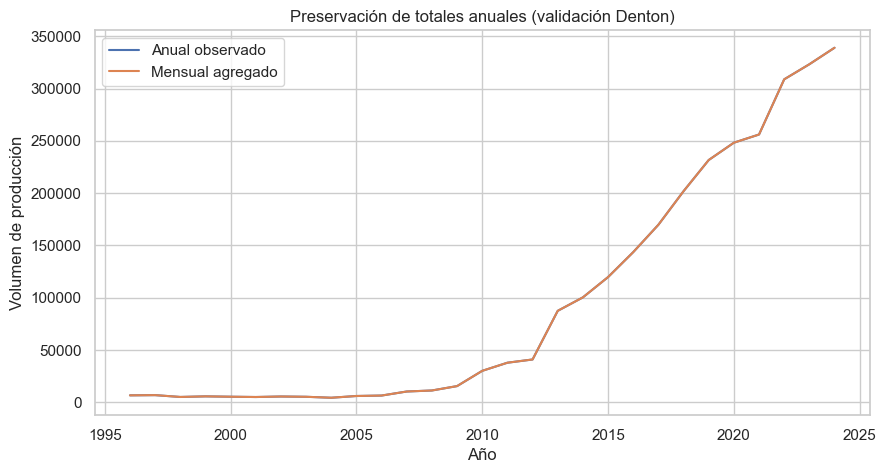

In [60]:
# Gráfica de validación
plt.figure()
plt.plot(df_check["Anio"], df_check["Volumen_anual_observado"], label="Anual observado")
plt.plot(df_check["Anio"], df_check["Volumen_mensual_agregado"], label="Mensual agregado")
plt.xlabel("Año")
plt.ylabel("Volumen de producción")
plt.title("Preservación de totales anuales (validación Denton)")
plt.legend()
plt.show()

##### Estacionalidad mensual promedio

Se analiza la distribución promedio de la producción a lo largo del año con el fin de identificar patrones estacionales implícitos y validar que la estructura temporal resultante sea razonable.

In [61]:
# Calcular estacionalidad promedio
df_estacionalidad = (
    df_master_mensual
    .groupby("Mes", as_index=False)["share_mes"]
    .mean()
)

df_estacionalidad

,Mes,share_mes
0,1,0.13
1,2,0.10
2,3,0.10
3,4,0.09
4,5,0.06
5,6,0.05
6,7,0.04
7,8,0.05
8,9,0.06
9,10,0.08


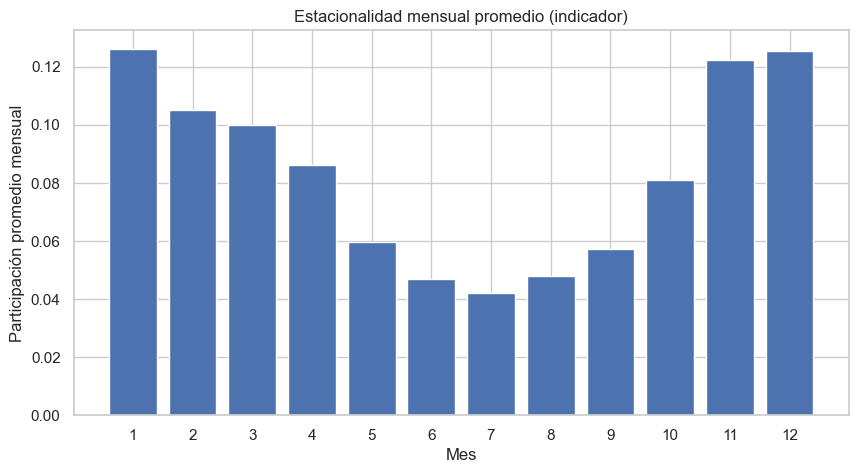

In [62]:
# Gráfica de estacionalidad mensual promedio
plt.figure()
plt.bar(df_estacionalidad["Mes"], df_estacionalidad["share_mes"])
plt.xlabel("Mes")
plt.ylabel("Participación promedio mensual")
plt.title("Estacionalidad mensual promedio (indicador)")
plt.xticks(range(1, 13))
plt.show()

##### Revisión visual de la serie mensual completa

Se examina la serie mensual completa mediante visualización gráfica para detectar posibles discontinuidades, valores atípicos o comportamientos anómalos derivados del proceso de estimación.

In [63]:
# Crear columna de fecha para graficar
df_master_mensual["Fecha"] = pd.to_datetime(
    dict(year=df_master_mensual["Anio"], month=df_master_mensual["Mes"], day=1)
)

# Agregar por mes (si hay modalidad)
df_mensual_total = (
    df_master_mensual
    .groupby("Fecha", as_index=False)["Volumenproduccion"]
    .sum()
)

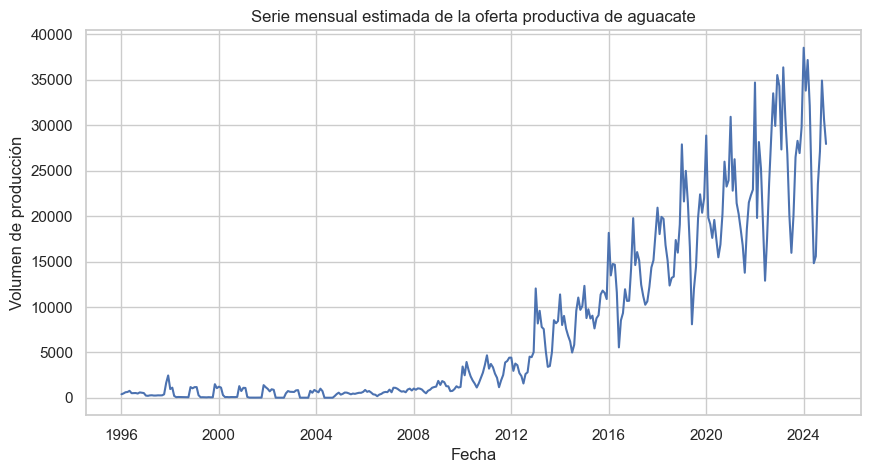

In [64]:
# Gráfica de la serie mensual estimada
plt.figure()
plt.plot(df_mensual_total["Fecha"], df_mensual_total["Volumenproduccion"])
plt.xlabel("Fecha")
plt.ylabel("Volumen de producción")
plt.title("Serie mensual estimada de la oferta productiva de aguacate")
plt.show()

### <a class="anchor" id="exportacion">8. Exportación de conjuntos de datos</a>

Una vez concluida la etapa de integración y homologación de datos, el conjunto de datos resultante se exporta para su reutilización en las etapas posteriores de análisis exploratorio, ingeniería de características y modelado.

In [65]:
# Guardar DataFrames maestros a CSV
df_master_anual.to_csv(
    PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv",
    index=False,
    encoding="utf-8"
)

df_master_mensual.to_csv(
    PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv",
    index=False
)

### <a class="anchor" id="eda">9. Análisis exploratorio de datos (EDA)</a>

Cargamos el DataFrame maestro.

In [66]:
df = pd.read_csv(PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv")
df.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato,Fecha
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado,1996-03-01


*¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?*

In [67]:
# Porcentaje de valores faltantes
num_rows = df.shape[0]
print("Valores nulos:\n")

for col in df.columns:
    na = ((df[col].notna().count() - num_rows) * 100) / num_rows
    print(f'{col}: {na}')

Valores nulos:

Anio: 0.0
Nommodalidad: 0.0
Sembrada: 0.0
Cosechada: 0.0
Siniestrada: 0.0
Volumenproduccion: 0.0
Valorproduccion: 0.0
Rendimiento: 0.0
Precio: 0.0
Mes: 0.0
share_mes: 0.0
Frecuencia: 0.0
TipoDato: 0.0
Fecha: 0.0


Para este dataset no se cuentan con datos faltantes en ninguna columna, lo cual es de mucha ayuda para ahorrarnos el proceso de imputar datos o deshacernos de columnas severamente dañadas. Cabe señalar que, en el caso de las variables mensuales, los valores provienen de un procedimiento de desagregación temporal previamente descrito.

*¿Cuáles son las estadísticas resumidas del conjunto de datos?*

In [68]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    str    
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    str    
 12  TipoDato           696 non-null    str    
 13  Fecha              696 non-null    str    
dtypes: float64(8), int64(2), str(4)
memory usage: 76.3 KB


En nuestro dataset se puede observar que en su mayoría está compuesto por variables numéricas, siendo `Anio` y `Mes`, las únicas columnas con valores numéricos enteros, mientras que el resto son valores con decimales. La columna `Nommodalidad` es la principal variable categórica del conjunto de datos, acompañada por variables descriptivas adicionales como `Frecuencia` y `TipoDato`.

In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Anio,696.00,"2,010.00",8.37,"1,996.00","2,003.00","2,010.00","2,017.00","2,024.00"
Sembrada,696.00,"5,607.68","7,542.26",55.00,540.00,"3,186.27","5,479.01","27,627.94"
Cosechada,696.00,"4,334.14","6,541.05",55.00,438.50,"1,624.62","3,559.33","25,634.31"
Siniestrada,696.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Volumenproduccion,696.00,"3,930.35","6,828.98",0.65,238.08,"1,017.17","2,822.03","35,712.53"
Valorproduccion,696.00,"956,226,081.55","1,970,385,796.65","710,853.00","18,447,600.36","129,217,576.81","652,205,681.80","8,580,088,223.56"
Rendimiento,696.00,9.29,1.66,5.33,8.27,9.19,10.26,12.38
Precio,696.00,"12,050.84","7,354.58","1,657.00","5,885.34","11,214.66","16,145.98","32,102.94"
Mes,696.00,6.50,3.45,1.00,3.75,6.50,9.25,12.00
share_mes,696.00,0.08,0.05,0.00,0.06,0.08,0.10,0.36


En las estadísticas generales de las variables numéricas, se puede observar que la variable `Siniestrada` solo tiene valores de 0, ya que tanto su mínimo como su máximo tienen el mismo valor de 0, lo que indica que en nuestro dataset no existen registros que contemplen cantidad de territorio dañado. Por esto mismo es que se eliminará esta variable por no aportar ningún valor a nuestro dataset.

In [70]:
# Eliminar columna 'Siniestrada'
df = df.drop(columns=['Siniestrada'])
df.columns

Index(['Anio', 'Nommodalidad', 'Sembrada', 'Cosechada', 'Volumenproduccion',
       'Valorproduccion', 'Rendimiento', 'Precio', 'Mes', 'share_mes',
       'Frecuencia', 'TipoDato', 'Fecha'],
      dtype='str')

Otro detalle que se puede resaltar es la gran diversidad de precios que existen para el aguacate. Se puede observar que el precio promedio mínimo ronda en 20 pesos y el máximo en 32,000. Igualmente, a través de los cuartiles se puede analizar que la mayoría de los registros no tienen precios superiores a los 15,000, y son la minoría los que superan ese precio.

De la misma forma, se puede observar que existe una gran diferencia entre una mitad de registros y otra en cuanto al valor de producción, y es que a través de los cuartiles se puede ver que el 50% de los registros tienen un valor menor a 18,000,000; mientras que existe un 25% de registros que son mayores a esa cifra y menores de 306,000,000.

In [71]:
df.describe(exclude=np.number).T

,count,unique,top,freq
Nommodalidad,696,2,Riego,348
Frecuencia,696,1,Mensual,696
TipoDato,696,1,Estimado,696
Fecha,696,348,1996-01-01,2


En las estadísticas generales de las variables categóricas, se puede observar que la variable `Nommodalidad` solo contiene 2 tipos de categorías (Riego y Temporal), y aunque la estadística indica que el registro que más se repite es Riego, realmente ambas se repiten con la misma frecuencia, 348 veces cada una en un conjunto de 696 registros en total.

*¿Hay valores atípicos en el conjunto de datos?*

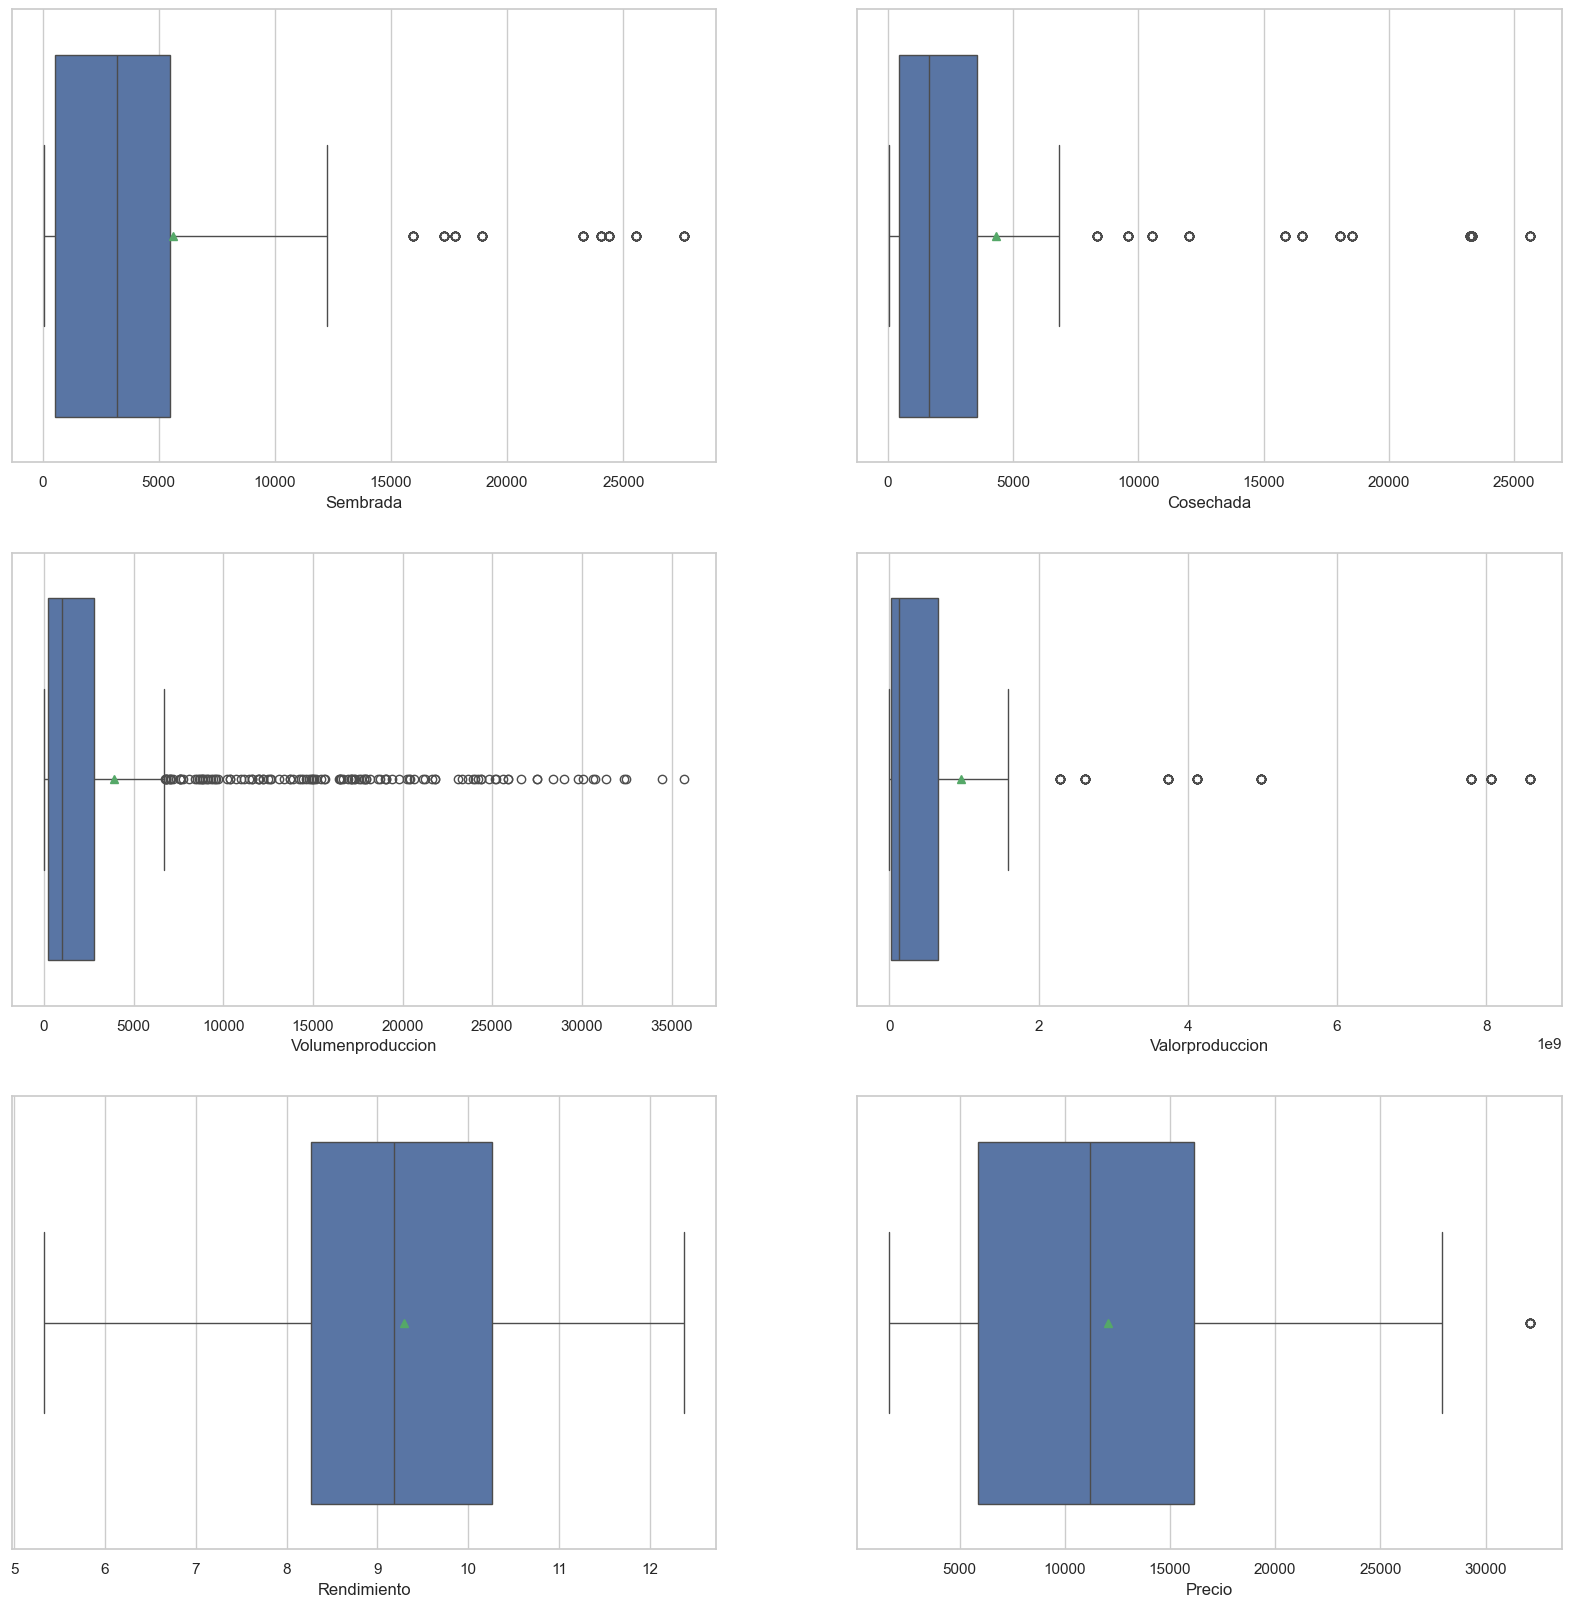

In [72]:
# Graficar matriz de box plots para demostrar valores atípicos
figure, axes = plt.subplots(3, 2, figsize = (20,20))
axes = axes.ravel()
num_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Rendimiento', 'Precio']

for col, ax in zip(num_cols, axes):
    sns.boxplot(x = df[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

A partir de los box plots de las variables productivas se observa la presencia de valores atípicos en la mayoría de las columnas numéricas. Estas observaciones extremas corresponden principalmente a meses con niveles de producción o superficies significativamente superiores al promedio histórico.

Ahora con la confirmación de la existencia de valores atípicos en la mayoría de las columnas, se procederá a identificar en el dataset los registros que son atípicos y luego se eliminarán.

In [73]:
# Identificación de valores atípicos y su eliminación del dataset
outlier_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Rendimiento', 'Precio']

for col in outlier_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    upper_cap = q3 + 1.5 * iqr
    lower_cap = q1 - 1.5 * iqr

    outliers = df[(df[col] > upper_cap) | (df[col] < lower_cap)][col]

    df = df[~df[col].isin(outliers)]

Dado que el objetivo principal de este análisis es exploratorio, se procedió a identificar valores extremos utilizando el criterio del rango intercuartílico (IQR). Es importante señalar que, en el contexto de datos mensuales estimados, estos valores atípicos no necesariamente representan errores, sino meses con niveles de producción inusualmente altos. Por lo tanto, la eliminación de outliers se realiza únicamente con fines de visualización y análisis descriptivo, y no como una limpieza definitiva para el modelado.

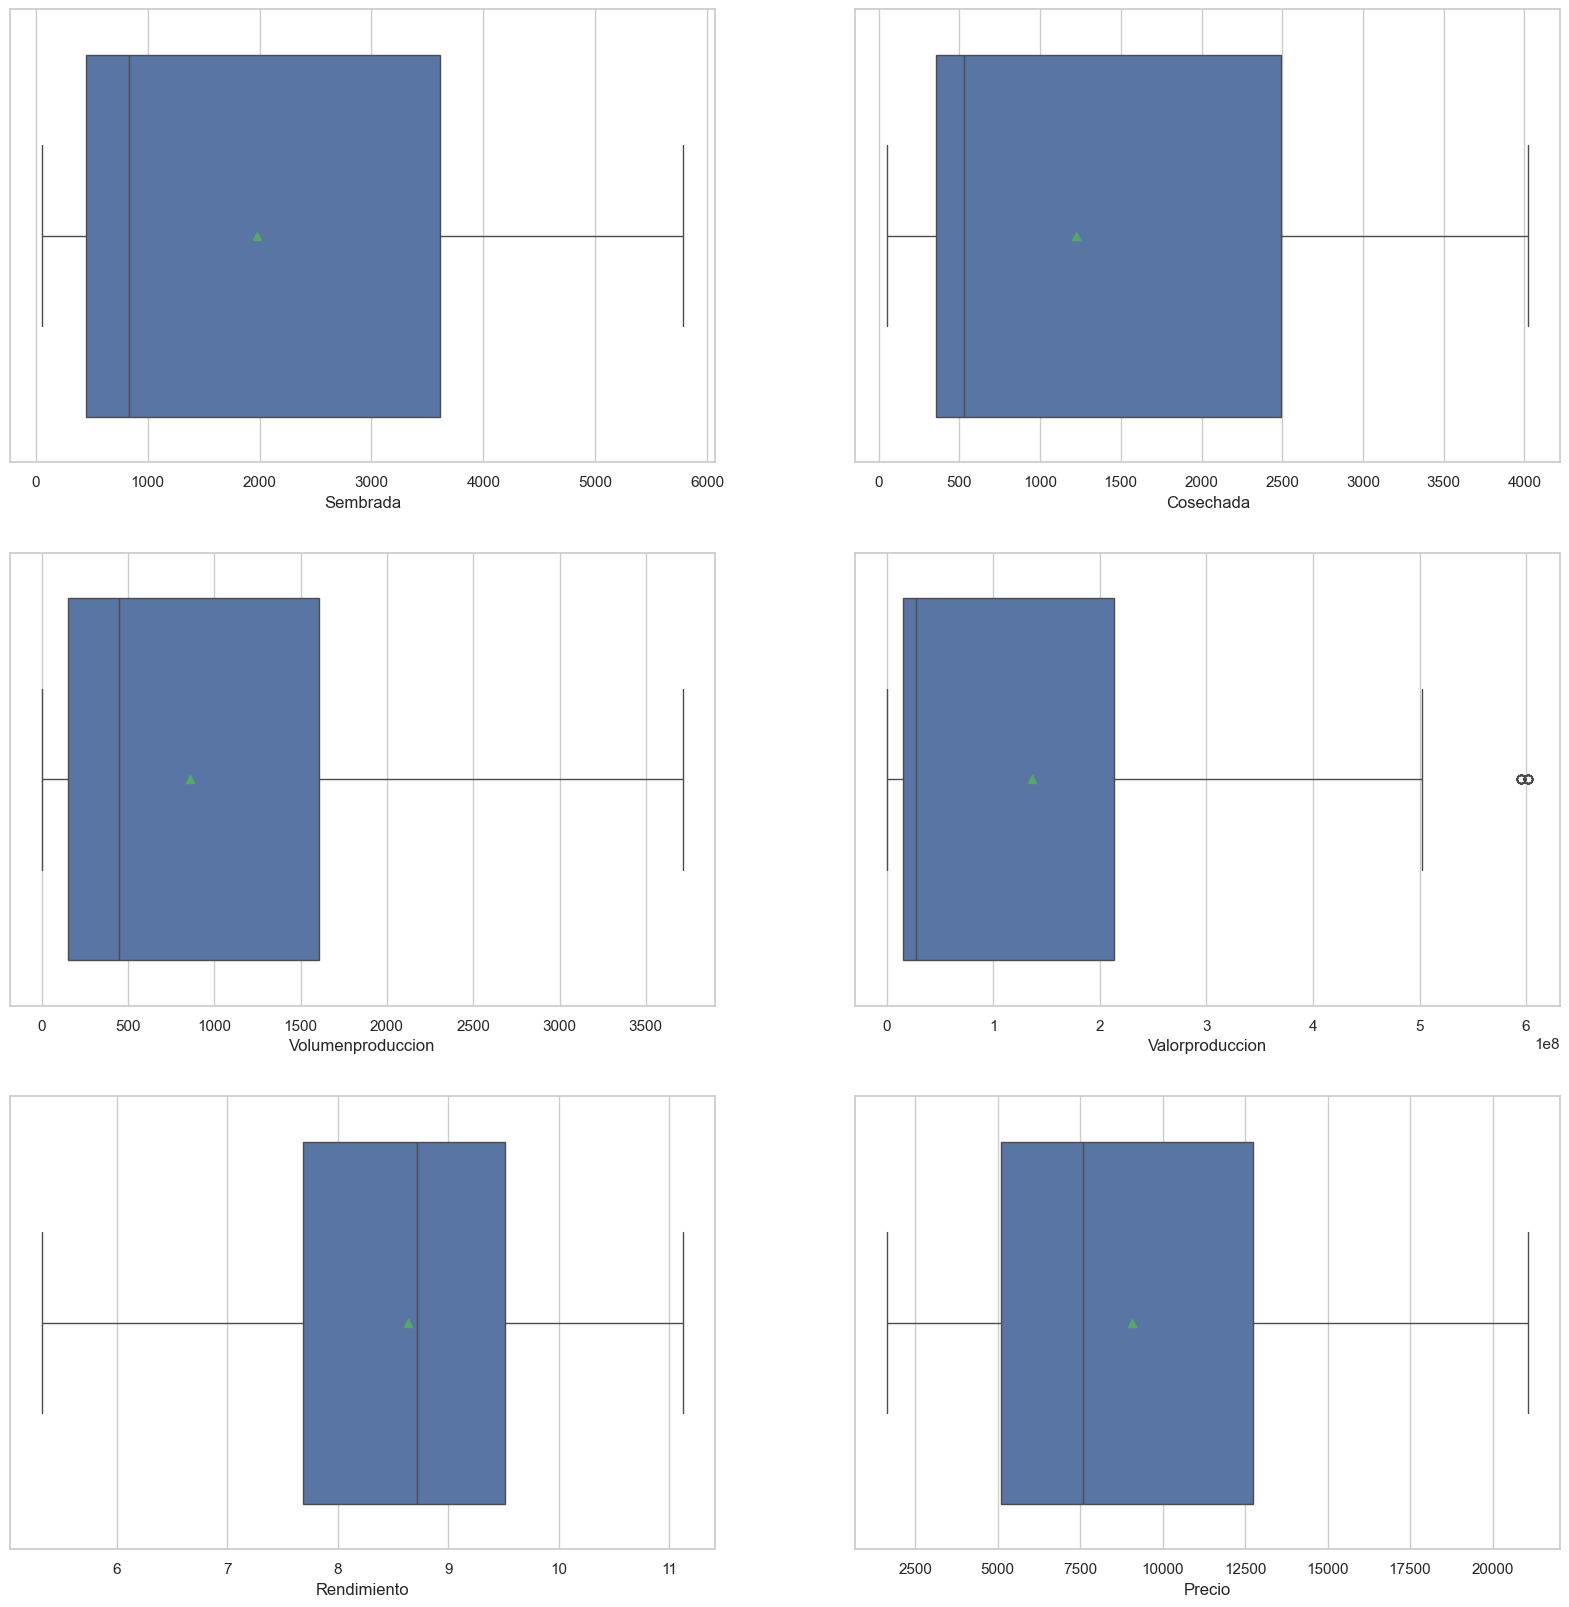

In [74]:
# Graficar matriz de box plots con el nuevo dataset limpio
figure, axes = plt.subplots(3, 2, figsize = (20,20))
axes = axes.ravel()

for col, ax in zip(outlier_cols, axes):
    sns.boxplot(x = df[col], ax = ax, showmeans = True)
    ax.set(xlabel = f'{col}')

Al eliminar los outliers que se habían identificado previamente, podemos ver gráficas de Box Plots más limpias ahora. Particularmente, las variables `Rendimiento` y `Precio` ya no presentan valores atípicos. No obstante, se puede observar que el resto de las variables presentan todavía valores atípicos, pero a comparación de antes, estos nuevos valores atípicos están más cercanos al valor máximo de su respectiva columna. Por ejemplo, la columna `Volumenproduccion` previamente tenía outliers que eran mayores a 50,000 llegando a tener hasta 300,000; ahora, tras este proceso de eliminación de outliers, aunque la variable todavía presenta valores atípicos, ahora la columna tiene al outlier más lejano en 25,000 lo cual permite una visualización más estable de las distribuciones centrales de las variables productivas.

*¿Cuál es la cardinalidad de las variables categóricas?*

<Axes: xlabel='Nommodalidad', ylabel='count'>

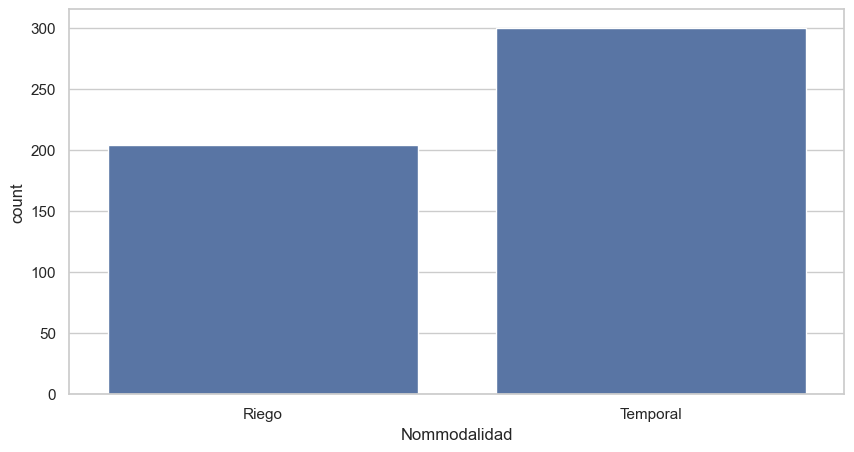

In [75]:
# Gráfica de barras
sns.countplot(x=df['Nommodalidad'])

Dado que el conjunto de datos mensual contiene una observación por mes y modalidad, la frecuencia de registros por modalidad no es directamente comparable con el dataset anual. En este nivel de análisis, las distribuciones reflejan diferencias en la dinámica mensual y estacional de la producción, y no el peso relativo de cada modalidad en términos anuales.

In [76]:
df['Nommodalidad'].value_counts()

Nommodalidad
Temporal    300
Riego       204
Name: count, dtype: int64

Tanto la visualización como el conteo de frecuencias muestran que la variable Nommodalidad presenta una distribución equilibrada entre las categorías Riego y Temporal a lo largo del periodo mensual analizado, lo cual evita problemas de desbalance en análisis posteriores.

*¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?*

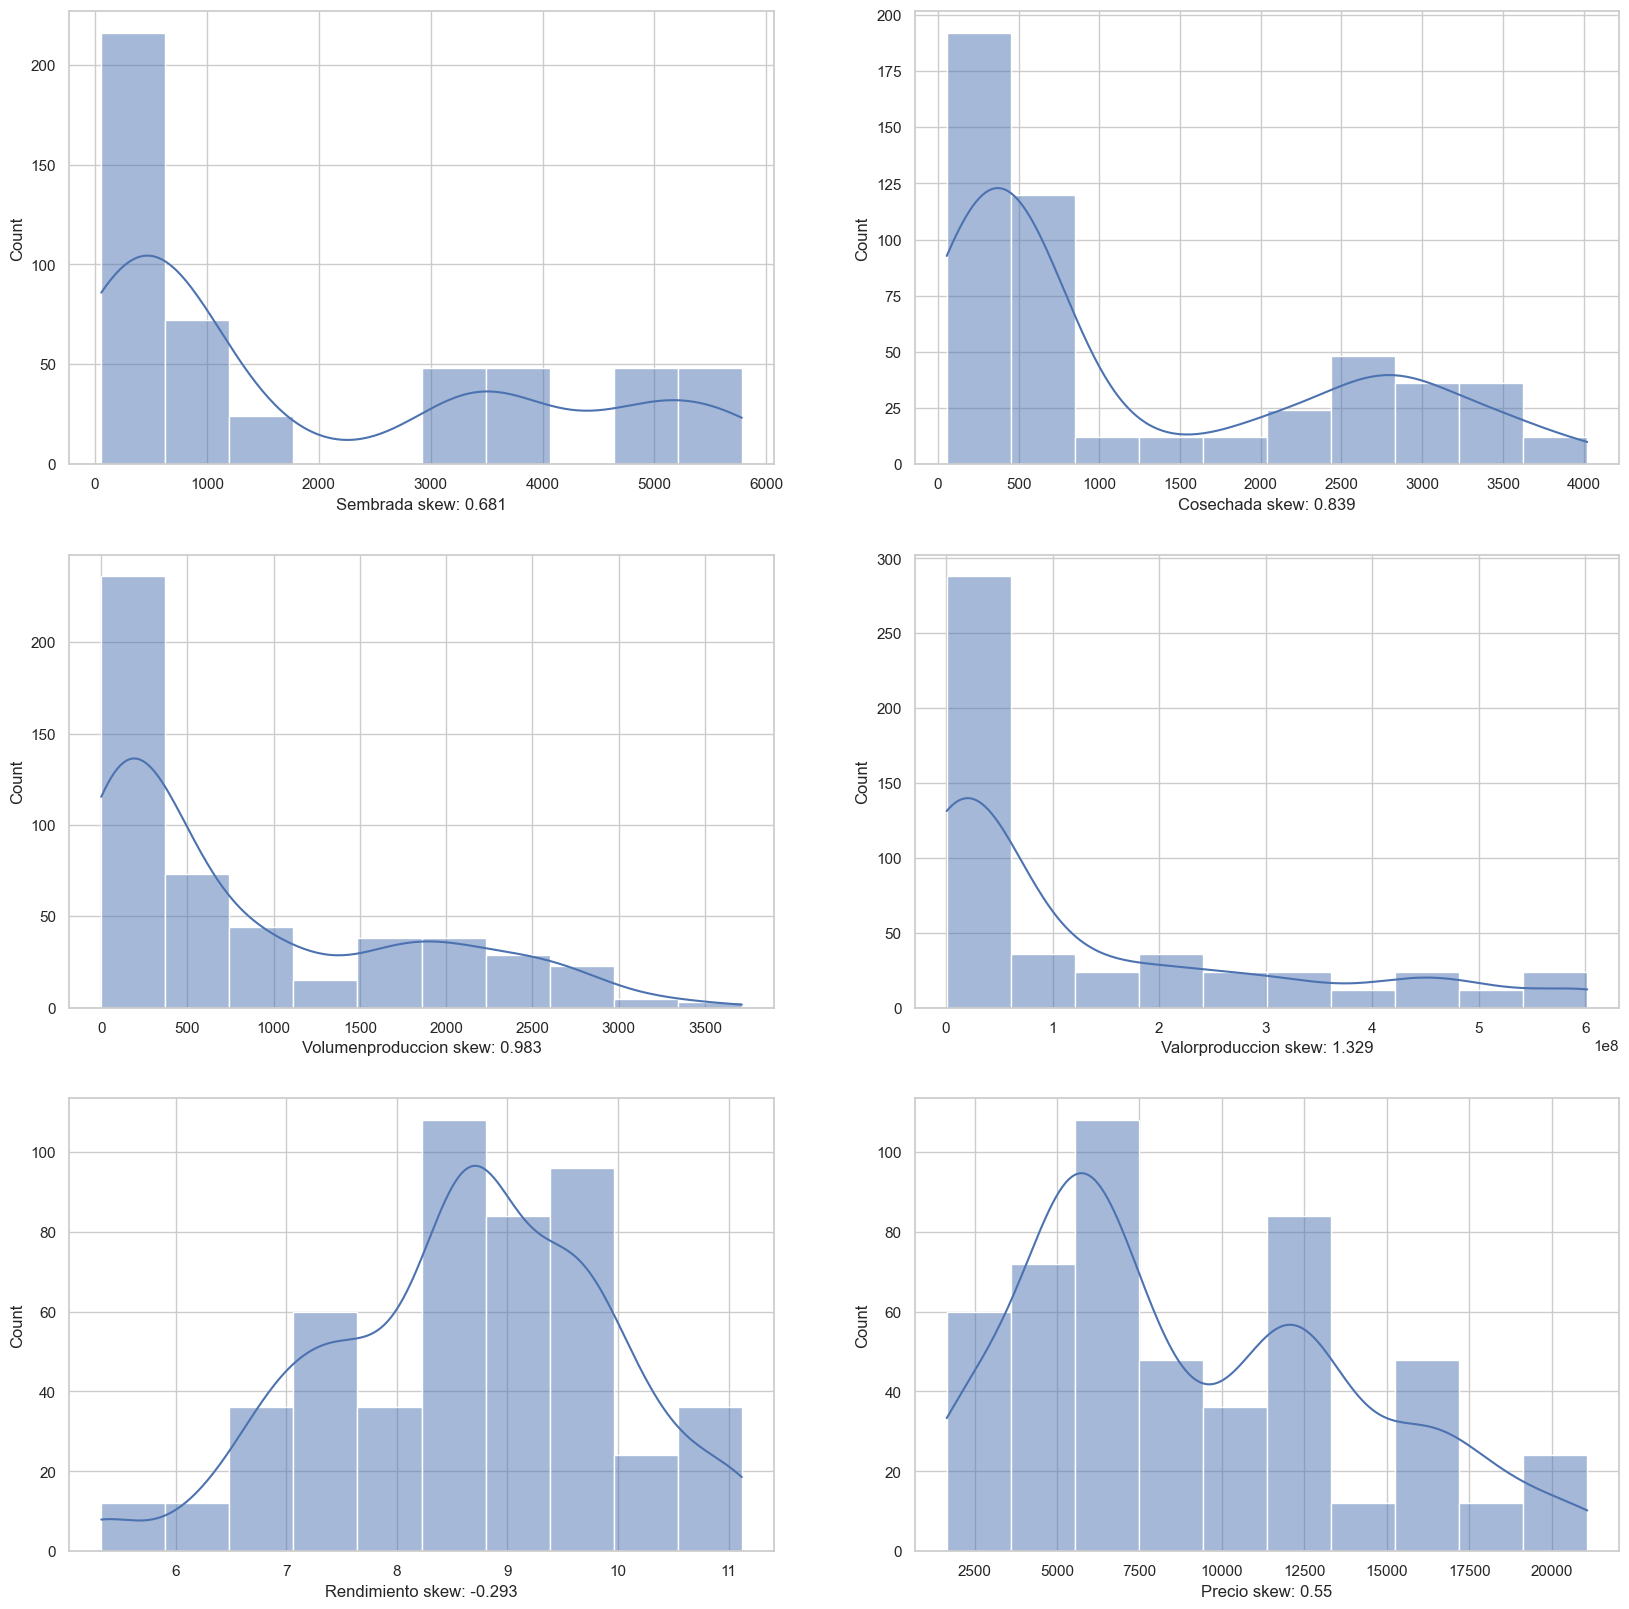

In [77]:
# Graficar matriz de histogramas para demostrar distribuciones de los datos
figure, axis = plt.subplots(3, 2, figsize=(20,20))
axis = axis.ravel()
df_og = df.copy()

for col, ax in zip(num_cols, axis):
    skew = round(df[col].skew(), 3)
    sns.histplot(x = df[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col} skew: {skew}')

En cuanto a los histogramas obtenidos por cada variable numérica, se puede destacar que las variables `Anio` y `Rendimiento` prácticamente no tienen asimetría, se puede observar en sus respectivos histogramas al observar que la distribución de los datos tiene una forma Gaussiana, y además porque numéricamente su asimetría es muy cercana a cero.

No obstante, el resto de las variables presentan asimetría positiva, primeramente porque todos sus datos se encuentran alineados a la izquierda en su gráfica de histograma, y porque su valor numérico es mayor a cero.

A estas variables con asimetría positiva se decidió aplicarles una transformación 'Box-Cox' ya que todos los valores presentes en cada columna son positivos, y además este método es una transformación más robusta que aplicar una transformación de raíz cuadrada, logarítmica, potencia etc.

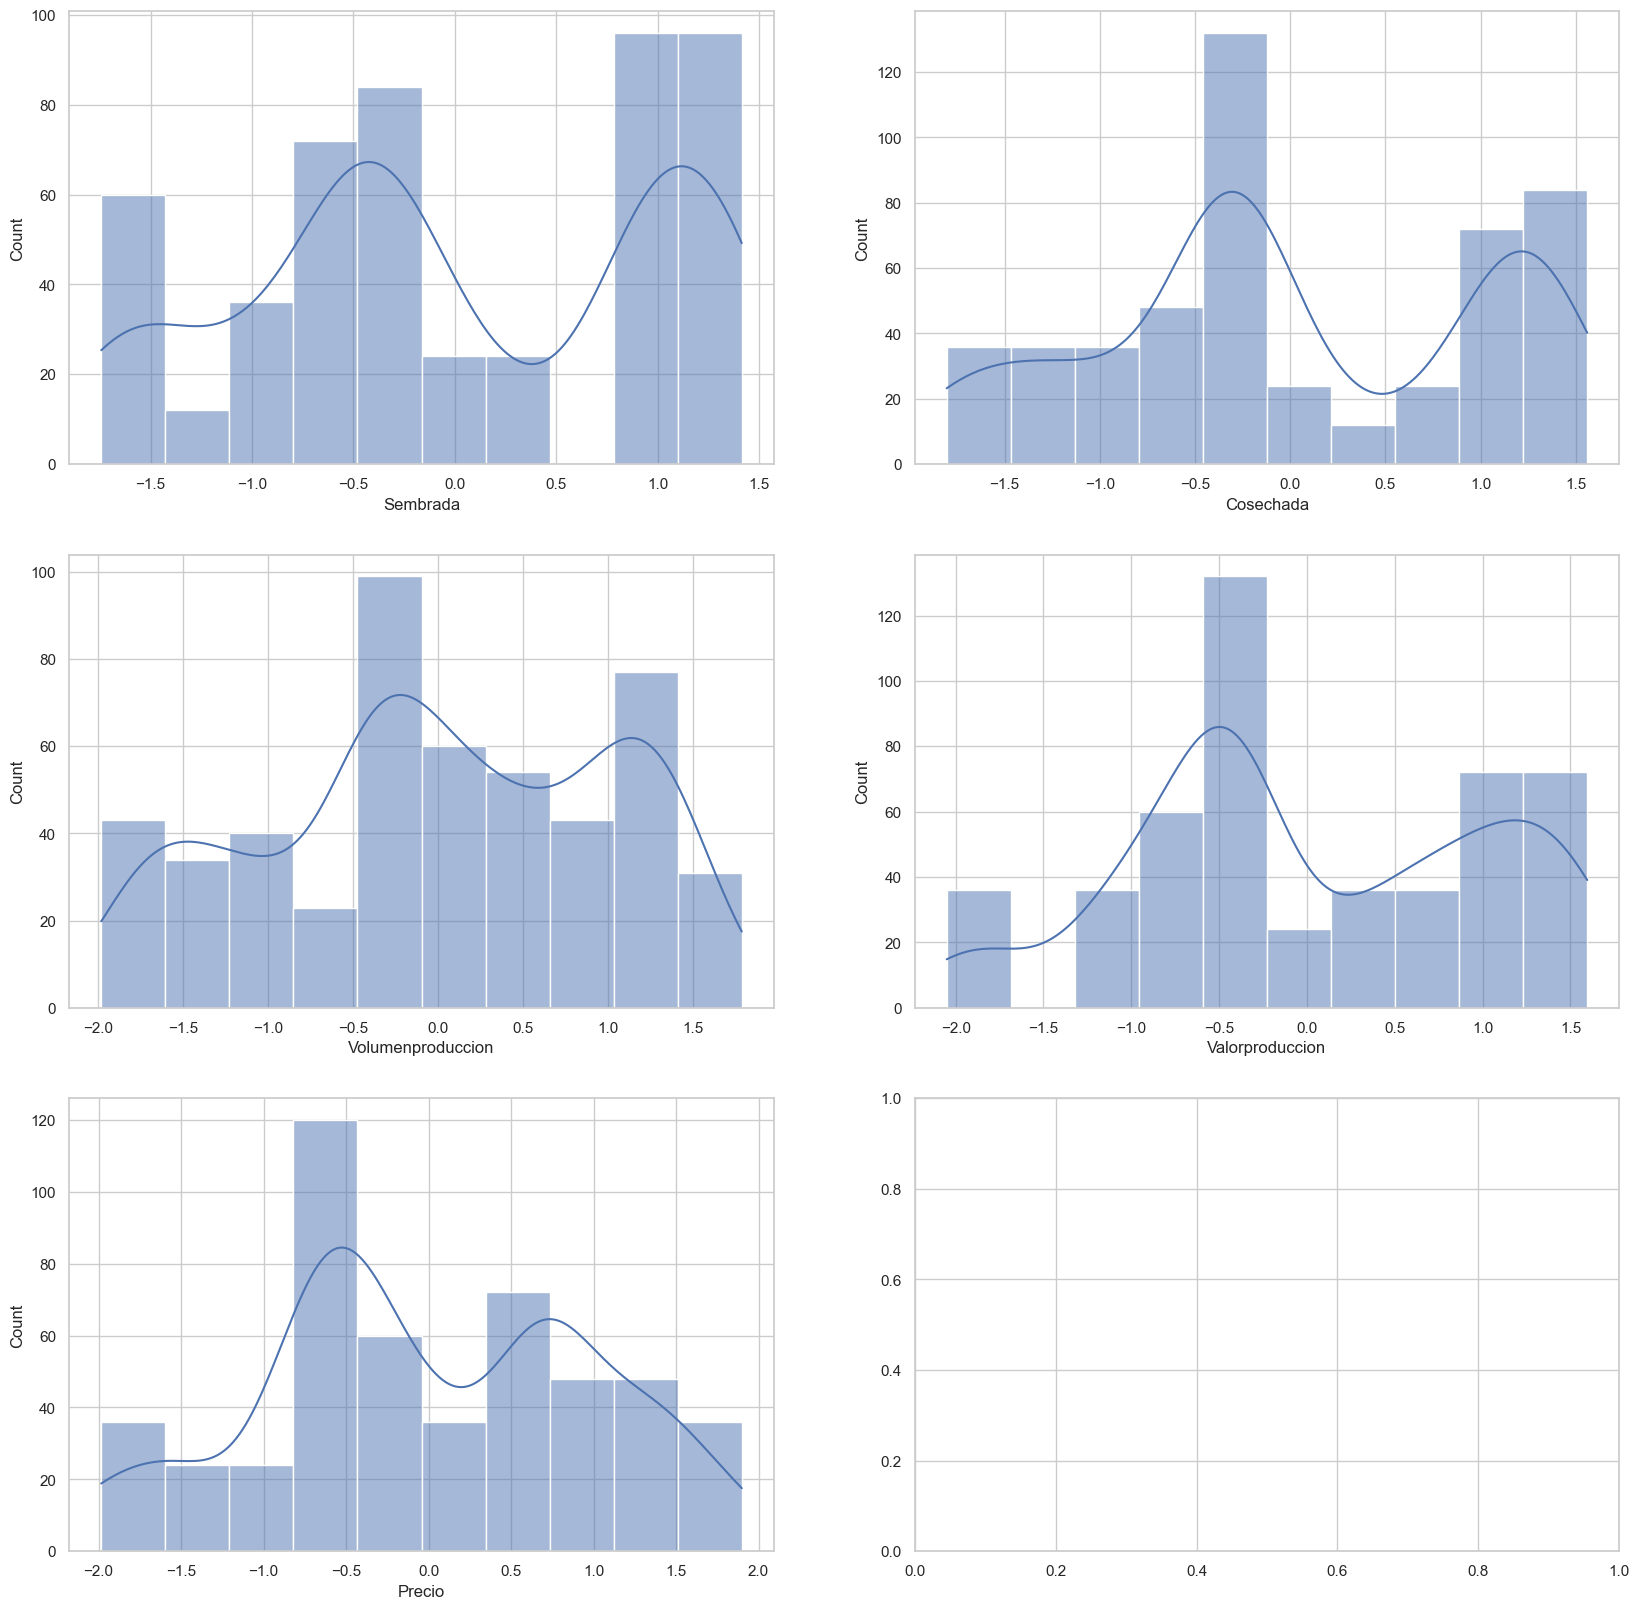

In [78]:
# Aplicar transformación Box-Cox y graficar matriz de histogramas con la nueva distribución
from sklearn.preprocessing import power_transform

figure, axis = plt.subplots(3, 2, figsize = (20,20))
axis = axis.ravel()
skewed_cols = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Precio']

for col, ax in zip(skewed_cols, axis):
    df[col] = power_transform(df[[col]], method = 'box-cox')
    sns.histplot(x = df[col], bins = 10, kde = True, ax = ax)
    ax.set(xlabel = f'{col}')

Dado que varias variables presentan asimetría positiva, se aplicó una transformación Box-Cox con fines exploratorios para evaluar la forma de las distribuciones bajo supuestos de normalidad. Esta transformación se utiliza únicamente para análisis descriptivo y no implica que los modelos finales deban entrenarse necesariamente sobre estas variables transformadas, especialmente considerando la naturaleza temporal del conjunto de datos.

Por otro lado, como se observó que la variable categórica `Nommodalidad` tiene la misma frecuencia para sus 2 tipos de respuestas, entonces no se encuentra sesgada y no requiere procesos adicionales de imputación ni balanceo.

*¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).*

Dado que el conjunto de datos cuenta con una dimensión temporal mensual representada por la variable Fecha, se emplearán los datos previos a cualquier transformación y, cuando sea necesario, se realizarán agregaciones anuales con fines descriptivos. Esto permite conservar la interpretabilidad de las magnitudes originales, considerando que los datos mensuales corresponden a una estimación obtenida mediante desagregación temporal.

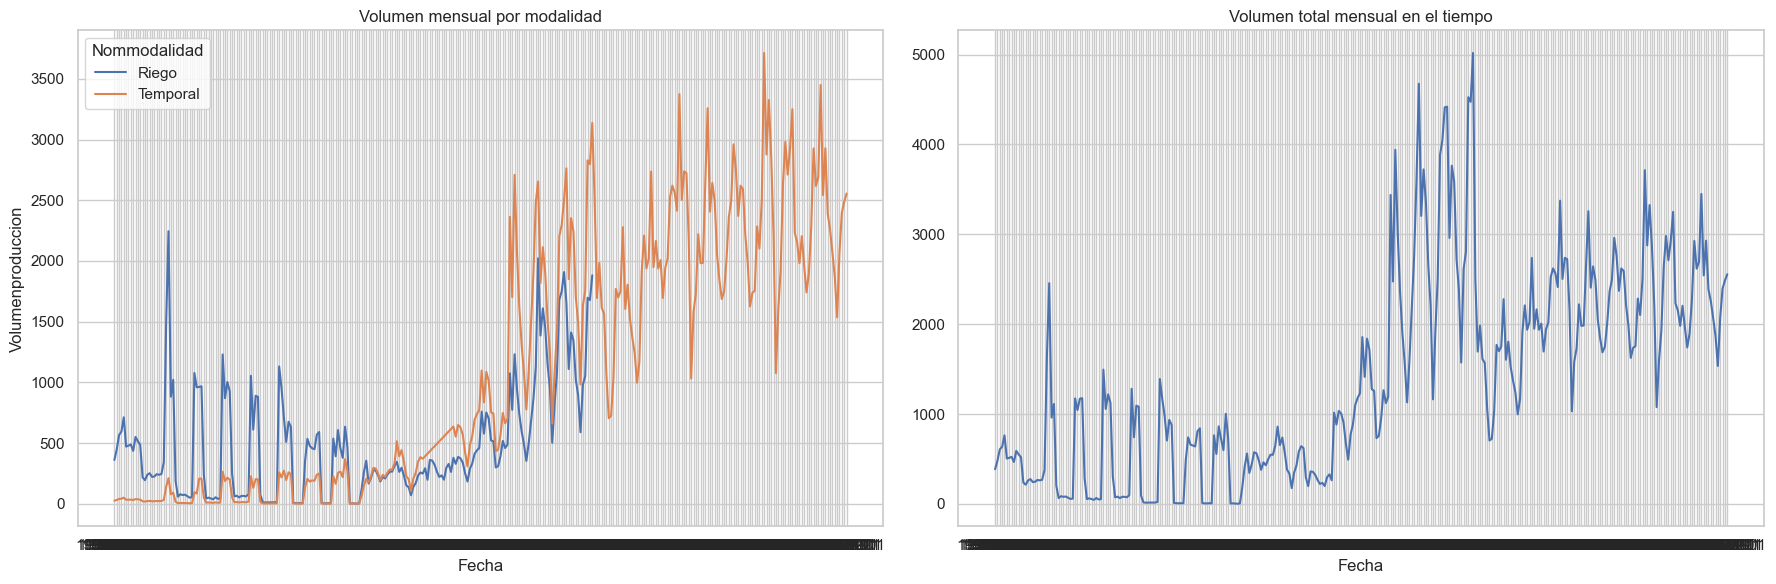

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

# Volumen mensual por modalidad
sns.lineplot(
    x="Fecha",
    y="Volumenproduccion",
    hue="Nommodalidad",
    data=df_og,
    ax=ax[0]
)
ax[0].set_title("Volumen mensual por modalidad")

# Volumen total mensual
df_og.groupby("Fecha")["Volumenproduccion"].sum().plot(ax=ax[1])
ax[1].set_title("Volumen total mensual en el tiempo")

plt.tight_layout()
plt.show()

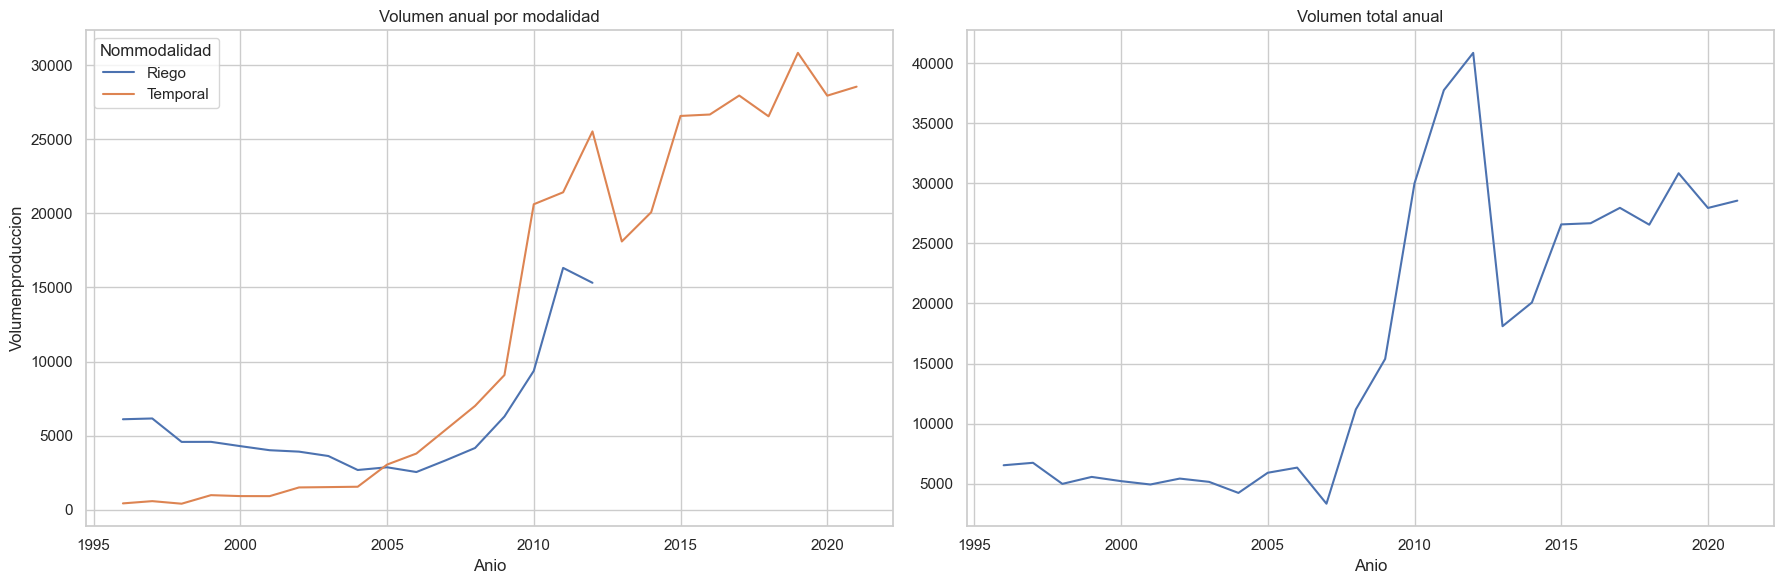

In [80]:
df_anual = (
    df_og
    .groupby(["Anio", "Nommodalidad"], as_index=False)
    ["Volumenproduccion"]
    .sum()
)

fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

sns.lineplot(
    x="Anio",
    y="Volumenproduccion",
    hue="Nommodalidad",
    data=df_anual,
    ax=ax[0]
)
ax[0].set_title("Volumen anual por modalidad")

df_anual.groupby("Anio")["Volumenproduccion"].sum().plot(ax=ax[1])
ax[1].set_title("Volumen total anual")

plt.tight_layout()
plt.show()

En estos gráficos se observa la evolución mensual del volumen de producción estimado, tanto por modalidad como de forma agregada. Se aprecia una tendencia creciente de largo plazo, así como variaciones intra-anuales que reflejan patrones estacionales inherentes a la producción agrícola del aguacate.

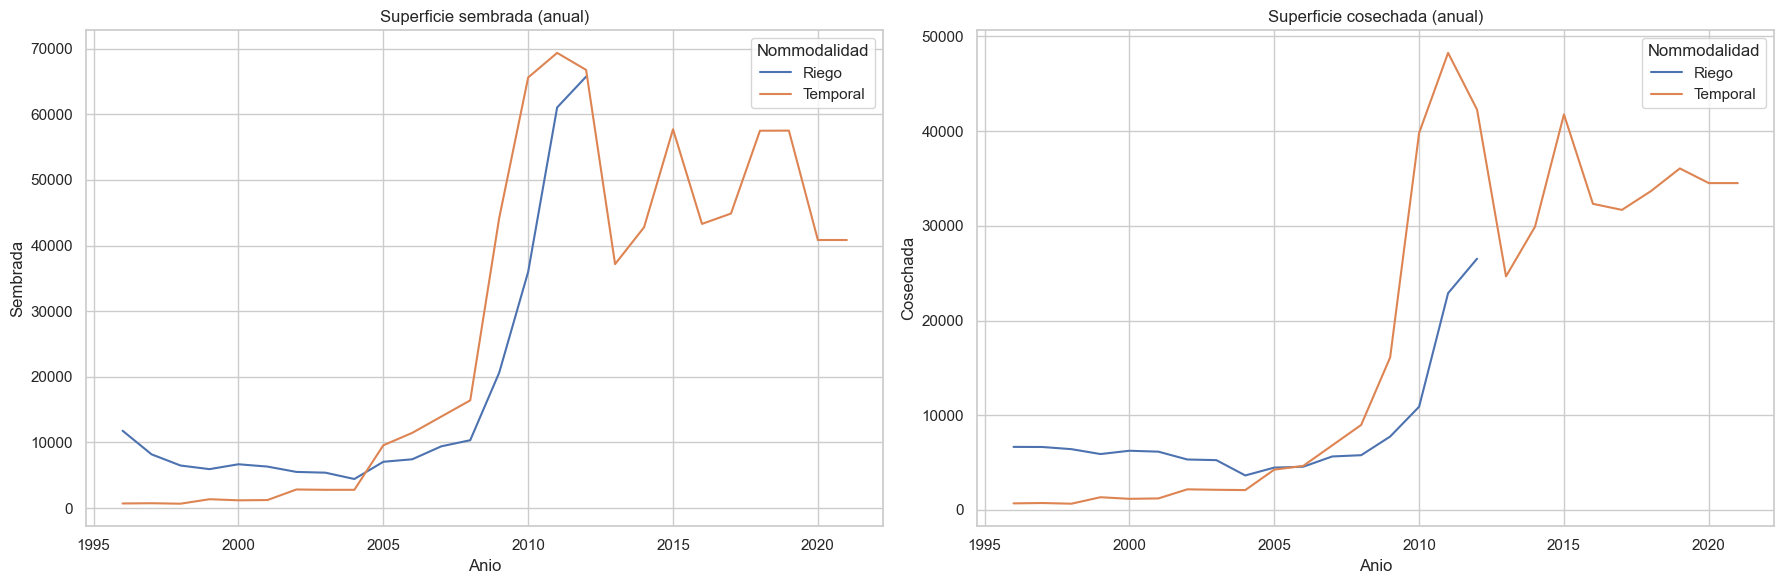

In [81]:
df_anual_sc = (
    df_og
    .groupby(["Anio", "Nommodalidad"], as_index=False)
    [["Sembrada", "Cosechada"]]
    .sum()
)

fig, ax = plt.subplots(1, 2, figsize=(18,6), sharex=True)

sns.lineplot(
    x="Anio", y="Sembrada", hue="Nommodalidad",
    data=df_anual_sc, ax=ax[0]
)
ax[0].set_title("Superficie sembrada (anual)")

sns.lineplot(
    x="Anio", y="Cosechada", hue="Nommodalidad",
    data=df_anual_sc, ax=ax[1]
)
ax[1].set_title("Superficie cosechada (anual)")

plt.tight_layout()
plt.show()

Para las variables de superficie sembrada y cosechada, se realizó una agregación anual, dado que su interpretación es más consistente a nivel anual que mensual. Los resultados muestran patrones temporales similares entre ambas variables, reflejando diferencias asociadas a pérdidas productivas y características propias de cada modalidad.

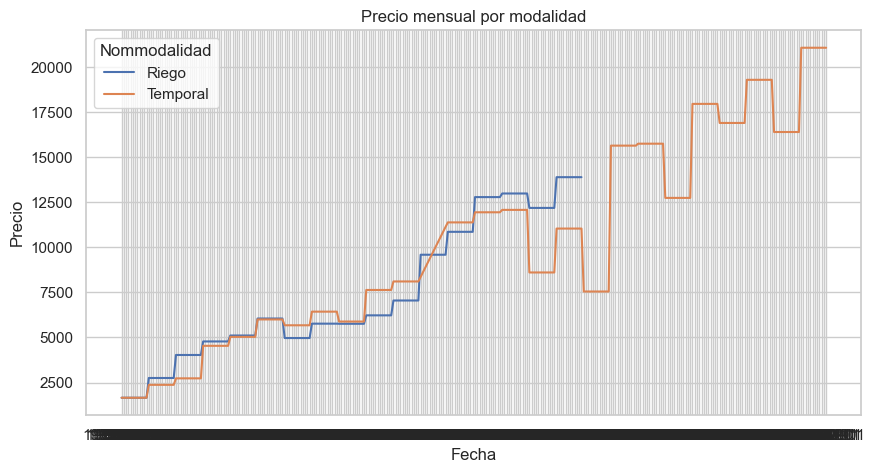

In [82]:
plt.figure(figsize=(10,5))
sns.lineplot(
    x="Fecha",
    y="Precio",
    hue="Nommodalidad",
    data=df_og
)
plt.title("Precio mensual por modalidad")
plt.show()

El precio presenta una tendencia creciente de largo plazo con fluctuaciones mensuales moderadas. Dado que el precio es una variable monetaria y potencialmente endógena, su análisis se limita a fines descriptivos y no se considera como variable explicativa principal del modelo predictivo.

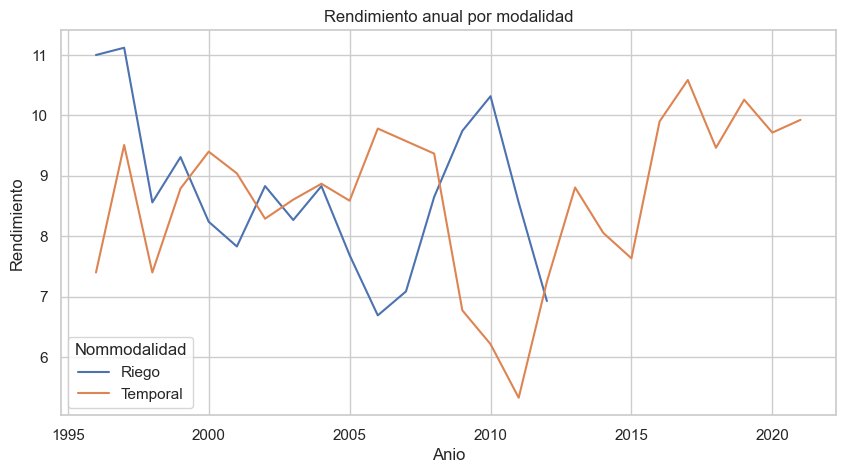

In [83]:
df_anual_rend = (
    df_og
    .groupby(["Anio", "Nommodalidad"], as_index=False)
    ["Rendimiento"]
    .mean()
)

plt.figure(figsize=(10,5))
sns.lineplot(
    x="Anio",
    y="Rendimiento",
    hue="Nommodalidad",
    data=df_anual_rend
)
plt.title("Rendimiento anual por modalidad")
plt.show()

El rendimiento anual muestra diferencias estructurales entre modalidades, con valores generalmente superiores en la modalidad de Riego. Sin embargo, en ciertos periodos se observan convergencias e incluso episodios donde la modalidad Temporal presenta rendimientos comparables, lo que podría asociarse a condiciones climáticas favorables o mejoras tecnológicas.

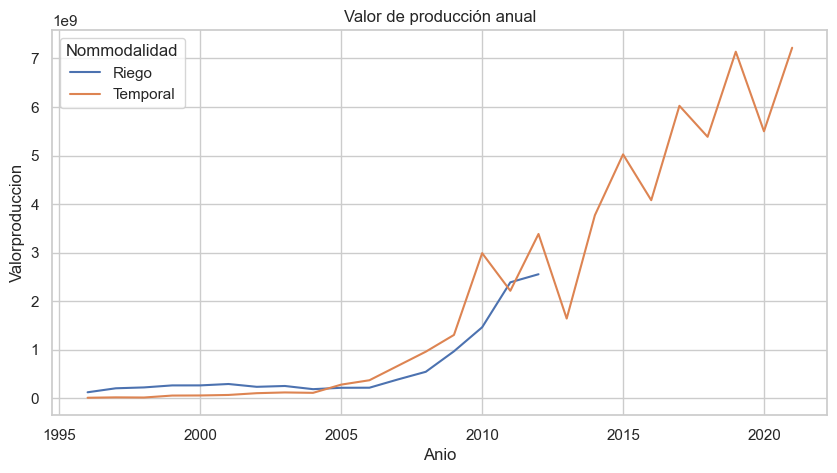

In [84]:
df_anual_valor = (
    df_og
    .groupby(["Anio", "Nommodalidad"], as_index=False)
    ["Valorproduccion"]
    .sum()
)

plt.figure(figsize=(10,5))
sns.lineplot(
    x="Anio",
    y="Valorproduccion",
    hue="Nommodalidad",
    data=df_anual_valor
)
plt.title("Valor de producción anual")
plt.show()

El valor de la producción presenta una tendencia creciente consistente, coherente con el aumento observado tanto en el volumen producido como en el precio. No obstante, al tratarse de una variable derivada, su análisis se utiliza únicamente como referencia descriptiva.

*¿Hay correlación entre las variables dependientes e independientes?*

Para identificar la relación entre la variable objetivo y el resto de las variables numéricas, se empleó una matriz de correlación utilizando los datos mensuales estimados. La variable temporal (Fecha) no se incluye explícitamente en el análisis de correlación, dado que el objetivo es evaluar asociaciones entre variables productivas y no su evolución en el tiempo.

Es importante señalar que, al tratarse de datos mensuales obtenidos mediante desagregación temporal, algunas correlaciones reflejan relaciones estructurales derivadas del proceso de construcción del dataset y no necesariamente relaciones causales directas.

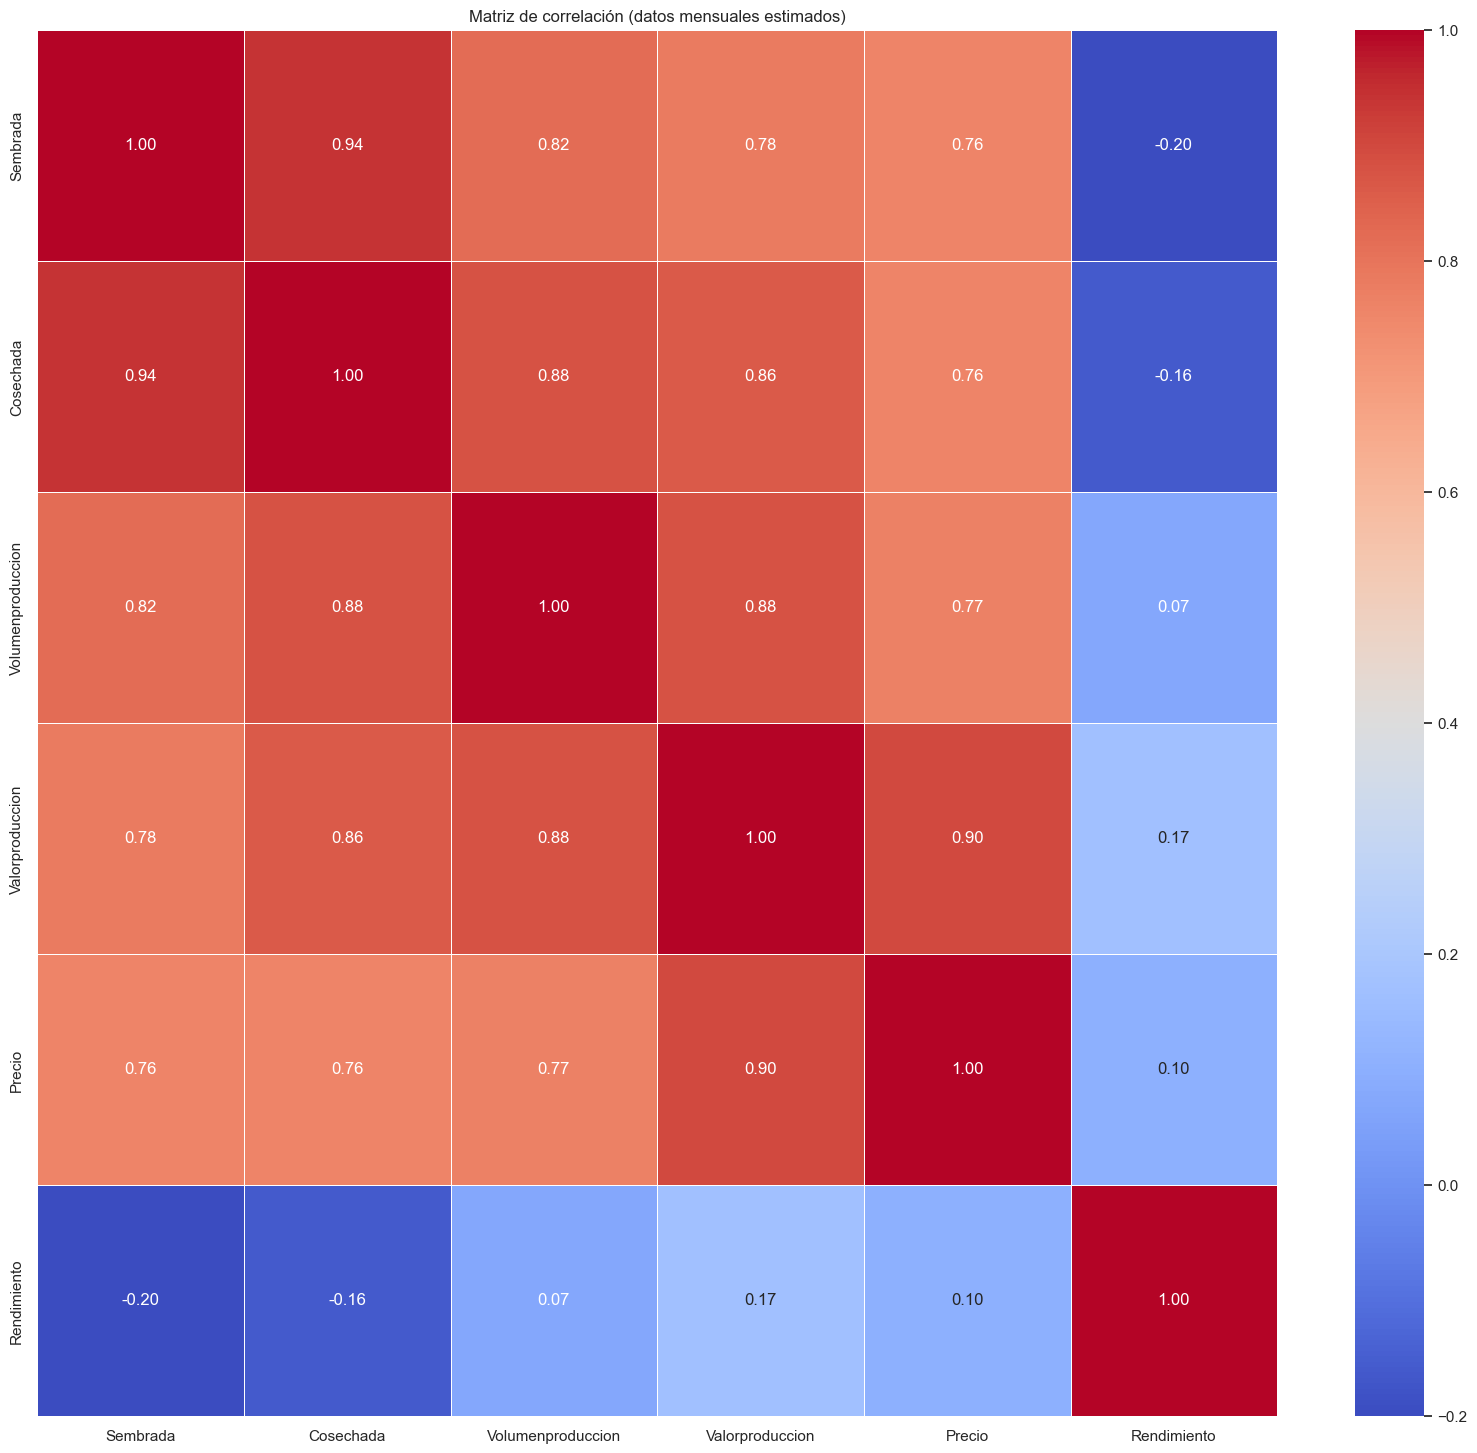

In [85]:
# Variables numéricas sin Anio
num_var = ['Sembrada', 'Cosechada', 'Volumenproduccion', 'Valorproduccion', 'Precio', 'Rendimiento']

plt.figure(figsize=(20,18))
sns.heatmap(round(df_og[num_var].corr(numeric_only=True),2), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación (datos mensuales estimados)")
plt.show()

Partiendo de que la variable dependiente corresponde a la variable objetivo, `Volumenproduccion`, y que las variables independientes son `Sembrada`, `Cosechada`, `Valorproduccion`, `Precio` y `Rendimiento`, se empleó una matriz de correlación para analizar la relación entre ellas.

En la matriz de correlación se observa una alta correlación positiva entre `Cosechada` y `Volumenproduccion` con 0.88, así como entre `Sembrada` y `Volumenproduccion` con 0.82, lo cual es esperable dado que estas variables están directamente relacionadas con el proceso de producción.

Asimismo, se identificó una alta correlación entre las variables independientes `Sembrada` y `Cosechada`, lo que sugiere la presencia de multicolinealidad, que es una fuerte correlación entre variables independientes que puede dificultar la interpretación de estas variables sobre la variable dependiente en modelos de regresión. No obstante, dado que este análisis forma parte del EDA, este aspecto será tomado en cuenta en etapas siguientes relacionadas con el modelado.

**Finalmente, se destaca que algunas correlaciones observadas pueden estar influenciadas por el proceso de desagregación temporal utilizado para construir el dataset mensual, por lo que estos resultados deben interpretarse como relaciones descriptivas y no causales**.

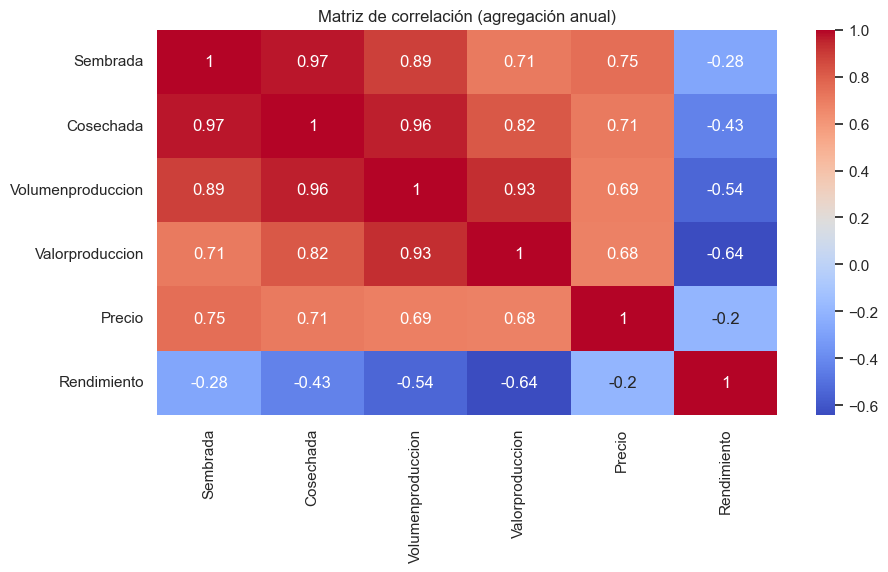

In [86]:
df_anual_corr = (df_og.groupby("Anio", as_index=False)[num_var].sum())

sns.heatmap(round(df_anual_corr[num_var].corr(), 2),annot=True,cmap="coolwarm")
plt.title("Matriz de correlación (agregación anual)")
plt.show()

La agregación anual permite validar que las relaciones estructurales observadas en el nivel mensual se mantienen al eliminar el efecto de la desagregación temporal.

*¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)*

Como ya se demostró anteriormente en la identificación de la cardinalidad de las variables categóricas, el dataset solo cuenta con una variable categórica de tipo nominal, la cual es `Nommodalidad`, misma que refleja las modalidades en que se dió la producción, siendo las opciones Riego y Temporal.

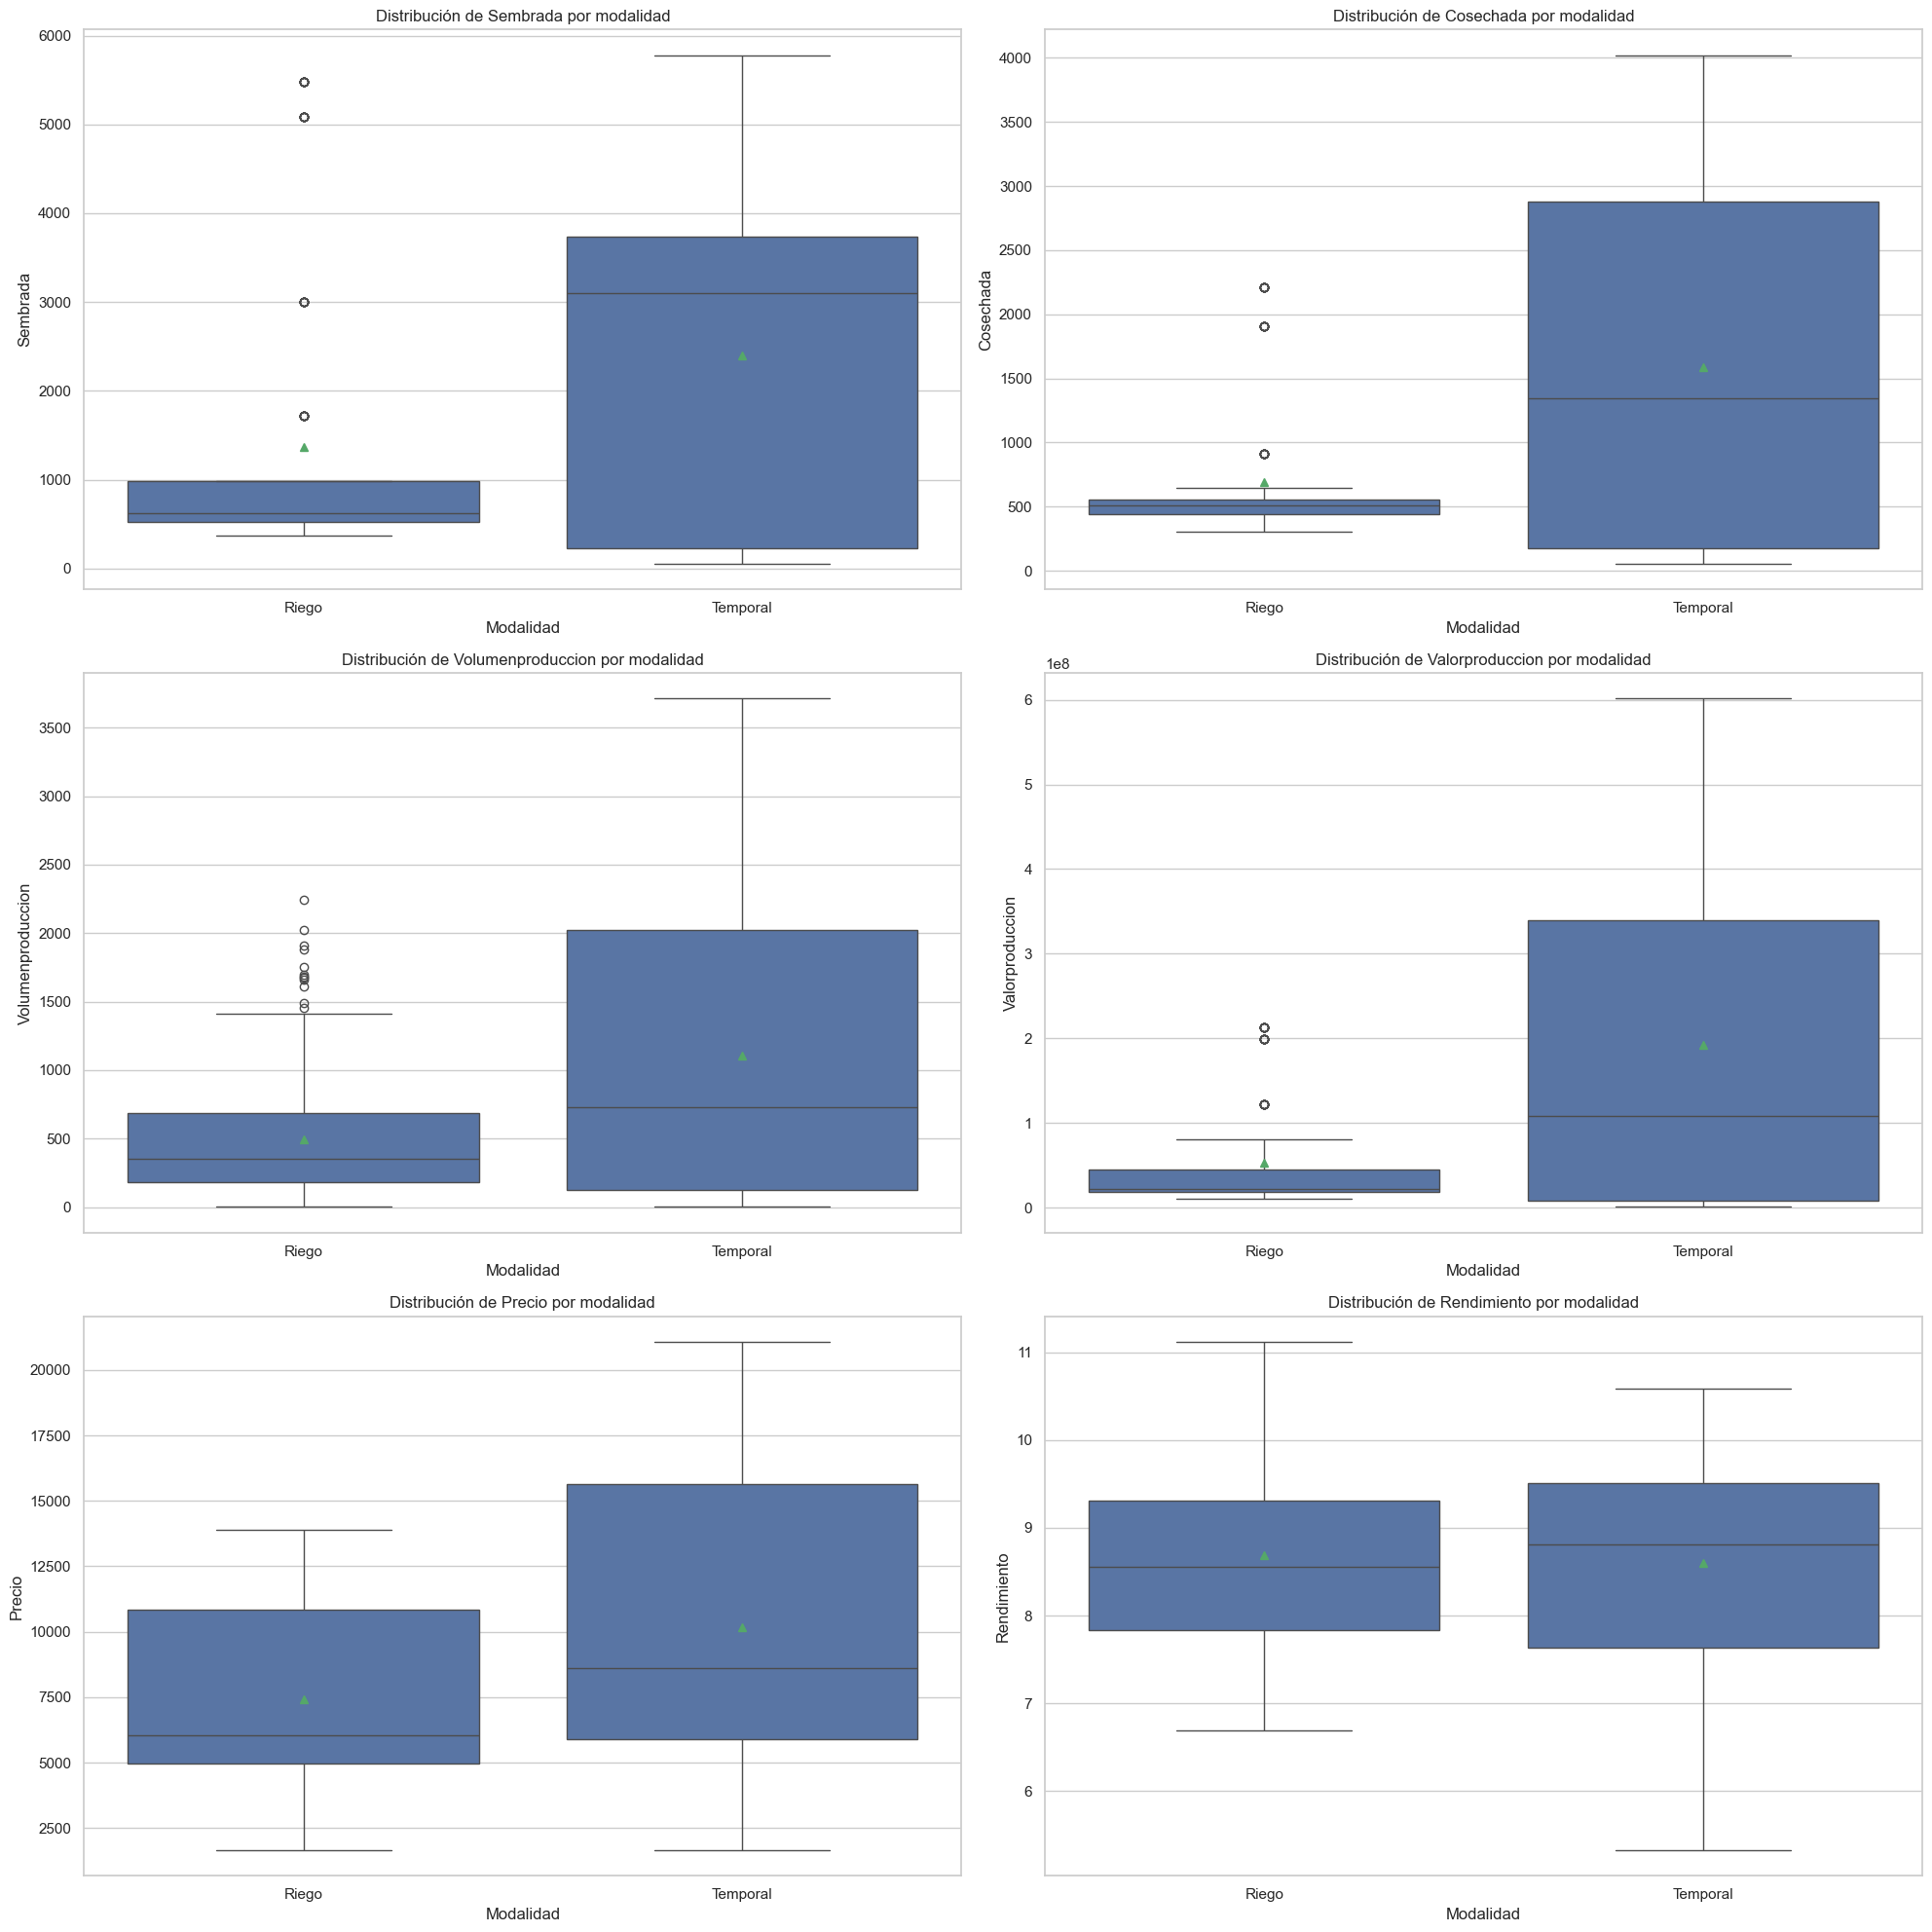

In [87]:
# Distribución de varaibles númericas con la variable categórica Nommodalidad
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.ravel()

for col, ax in zip(num_var, axes):
    sns.boxplot(x='Nommodalidad', y=col, data=df_og, showmeans=True, ax=ax)
    ax.set_title(f'Distribución de {col} por modalidad')
    ax.set_xlabel('Modalidad')
    ax.set_ylabel(col)
plt.tight_layout()

Para este análisis se utilizaron los datos previos a la transformación, ya que permiten una mejor interpretación de las magnitudes de las variables.

En la figura anterior se observa cómo cambia la distribución de cada variable numérica con respecto a la única variable categórica presente en el dataset `Nommodalidad`. En general, se muestra que la modalidad Riego, en la mayoría de los casos, tiene los valores más altos en variables como `Sembrada`, `Cosechada`, `Volumenproduccion` y `Valorproduccion`, mientras que la modalidad Temporal tiende a mostrar valores más bajos.

En cuanto a la dispersión, se observa una mayor variabilidad en la modalidad Riego para la variable `Sembrada`, así como en `Rendimiento`, mientras que en la variable `Precio` ambas modalidades presentan una dispersión elevada, lo que sugiere que los precios responden a factores de mercado más que a la modalidad productiva.

Cabe señalar que, dado que algunas variables fueron desagregadas temporalmente para obtener estimaciones mensuales, estas distribuciones deben interpretarse como comparaciones estructurales entre modalidades y no como diferencias mensuales observadas directamente en campo.

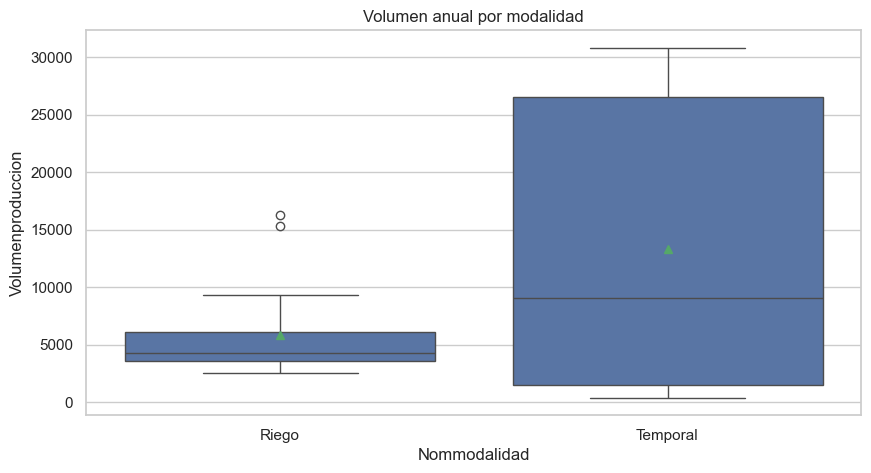

In [88]:
df_anual_biv = (
    df_og
    .groupby(["Anio", "Nommodalidad"], as_index=False)
    [num_var]
    .sum()
)

sns.boxplot(
    x="Nommodalidad",
    y="Volumenproduccion",
    data=df_anual_biv,
    showmeans=True
)
plt.title("Volumen anual por modalidad")
plt.show()

*¿Se deberían normalizar los datos para manejarlos mejor?*

Por medio de la normalización es posible contar con una escala más uniforme entre las variables, evitando que aquellas con magnitudes mayores dominen en ciertos modelos. Por esta razón, sí se puede aplicar una normalización ya que para modelos de tipo redes neuronales es recomendable, mientras que para modelos  de series de tiempo no es obligatorio. Debido a esto, el proceso de escalamiento se aplicará a una copia del dataset para que en futuras aplicaciones pueda utilizarse o no según el modelo que se decida implementar.

Partiendo de la transformación Box-Cox realizada anteriormente para reducir la asimetría y estabilizar la varianza de las variables, en los siguientes histogramas es posible visualizar nuevamente la distribución de las variables numéricas ya transformadas.

Dado que el conjunto de datos corresponde a una serie temporal mensual estimada, el proceso de escalamiento se aplicará sobre una copia del dataset, con el objetivo de preservar los valores originales para análisis interpretativos y permitir el uso flexible de versiones escaladas o no escaladas según el tipo de modelo que se decida implementar en etapas posteriores.

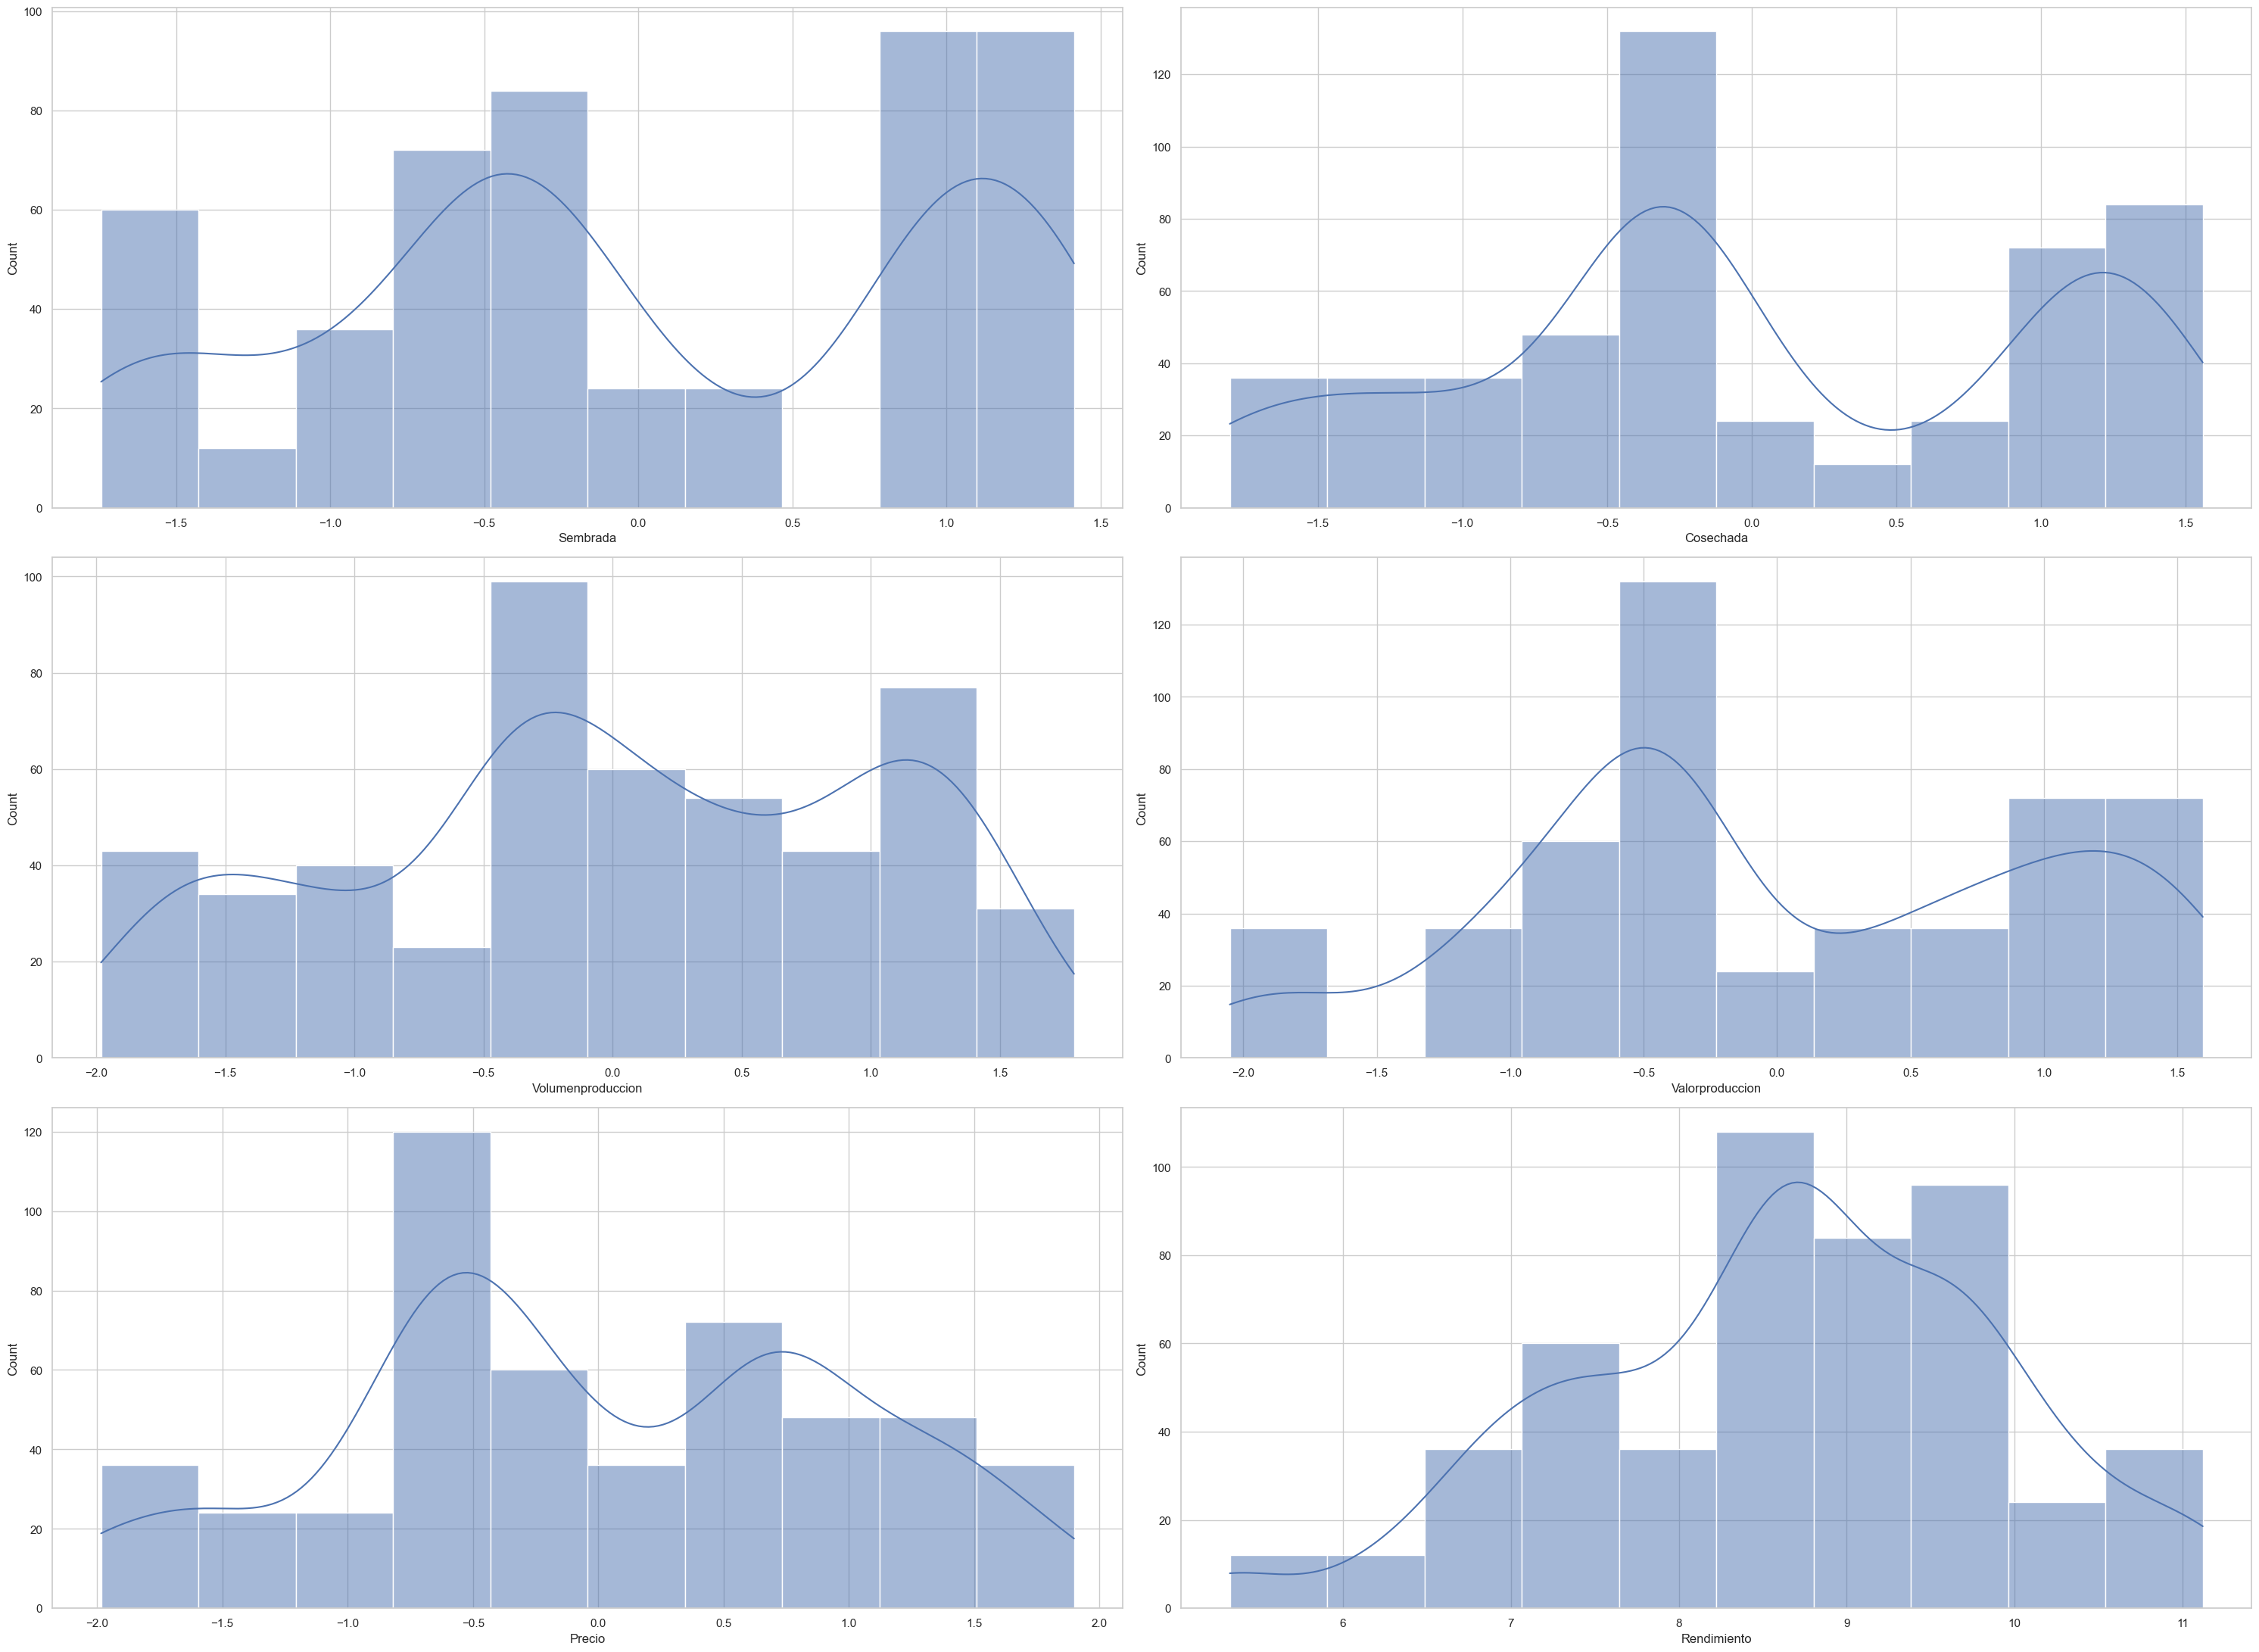

In [89]:
# Histogramas con varaibles numéricas transformadas
fig, axes = plt.subplots(3, 2, figsize=(30, 22))
for col, ax in zip(num_var, axes.ravel()):
    sns.histplot(df[col], bins=10, kde=True, ax=ax)
plt.tight_layout()
plt.show()

A partir de los histogramas obtenidos, se observa que las variables numéricas presentan distribuciones aproximadamente simétricas y sin sesgos pronunciados. Bajo estas condiciones, una normalización de tipo MinMax resulta adecuada, ya que permite reescalar las variables a un rango común [0,1] sin alterar la forma de sus distribuciones.

In [90]:
from sklearn.preprocessing import MinMaxScaler

# Aplicación de normalización MinMax al dataset después de las transformaciones
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[num_var] = scaler.fit_transform(df[num_var])

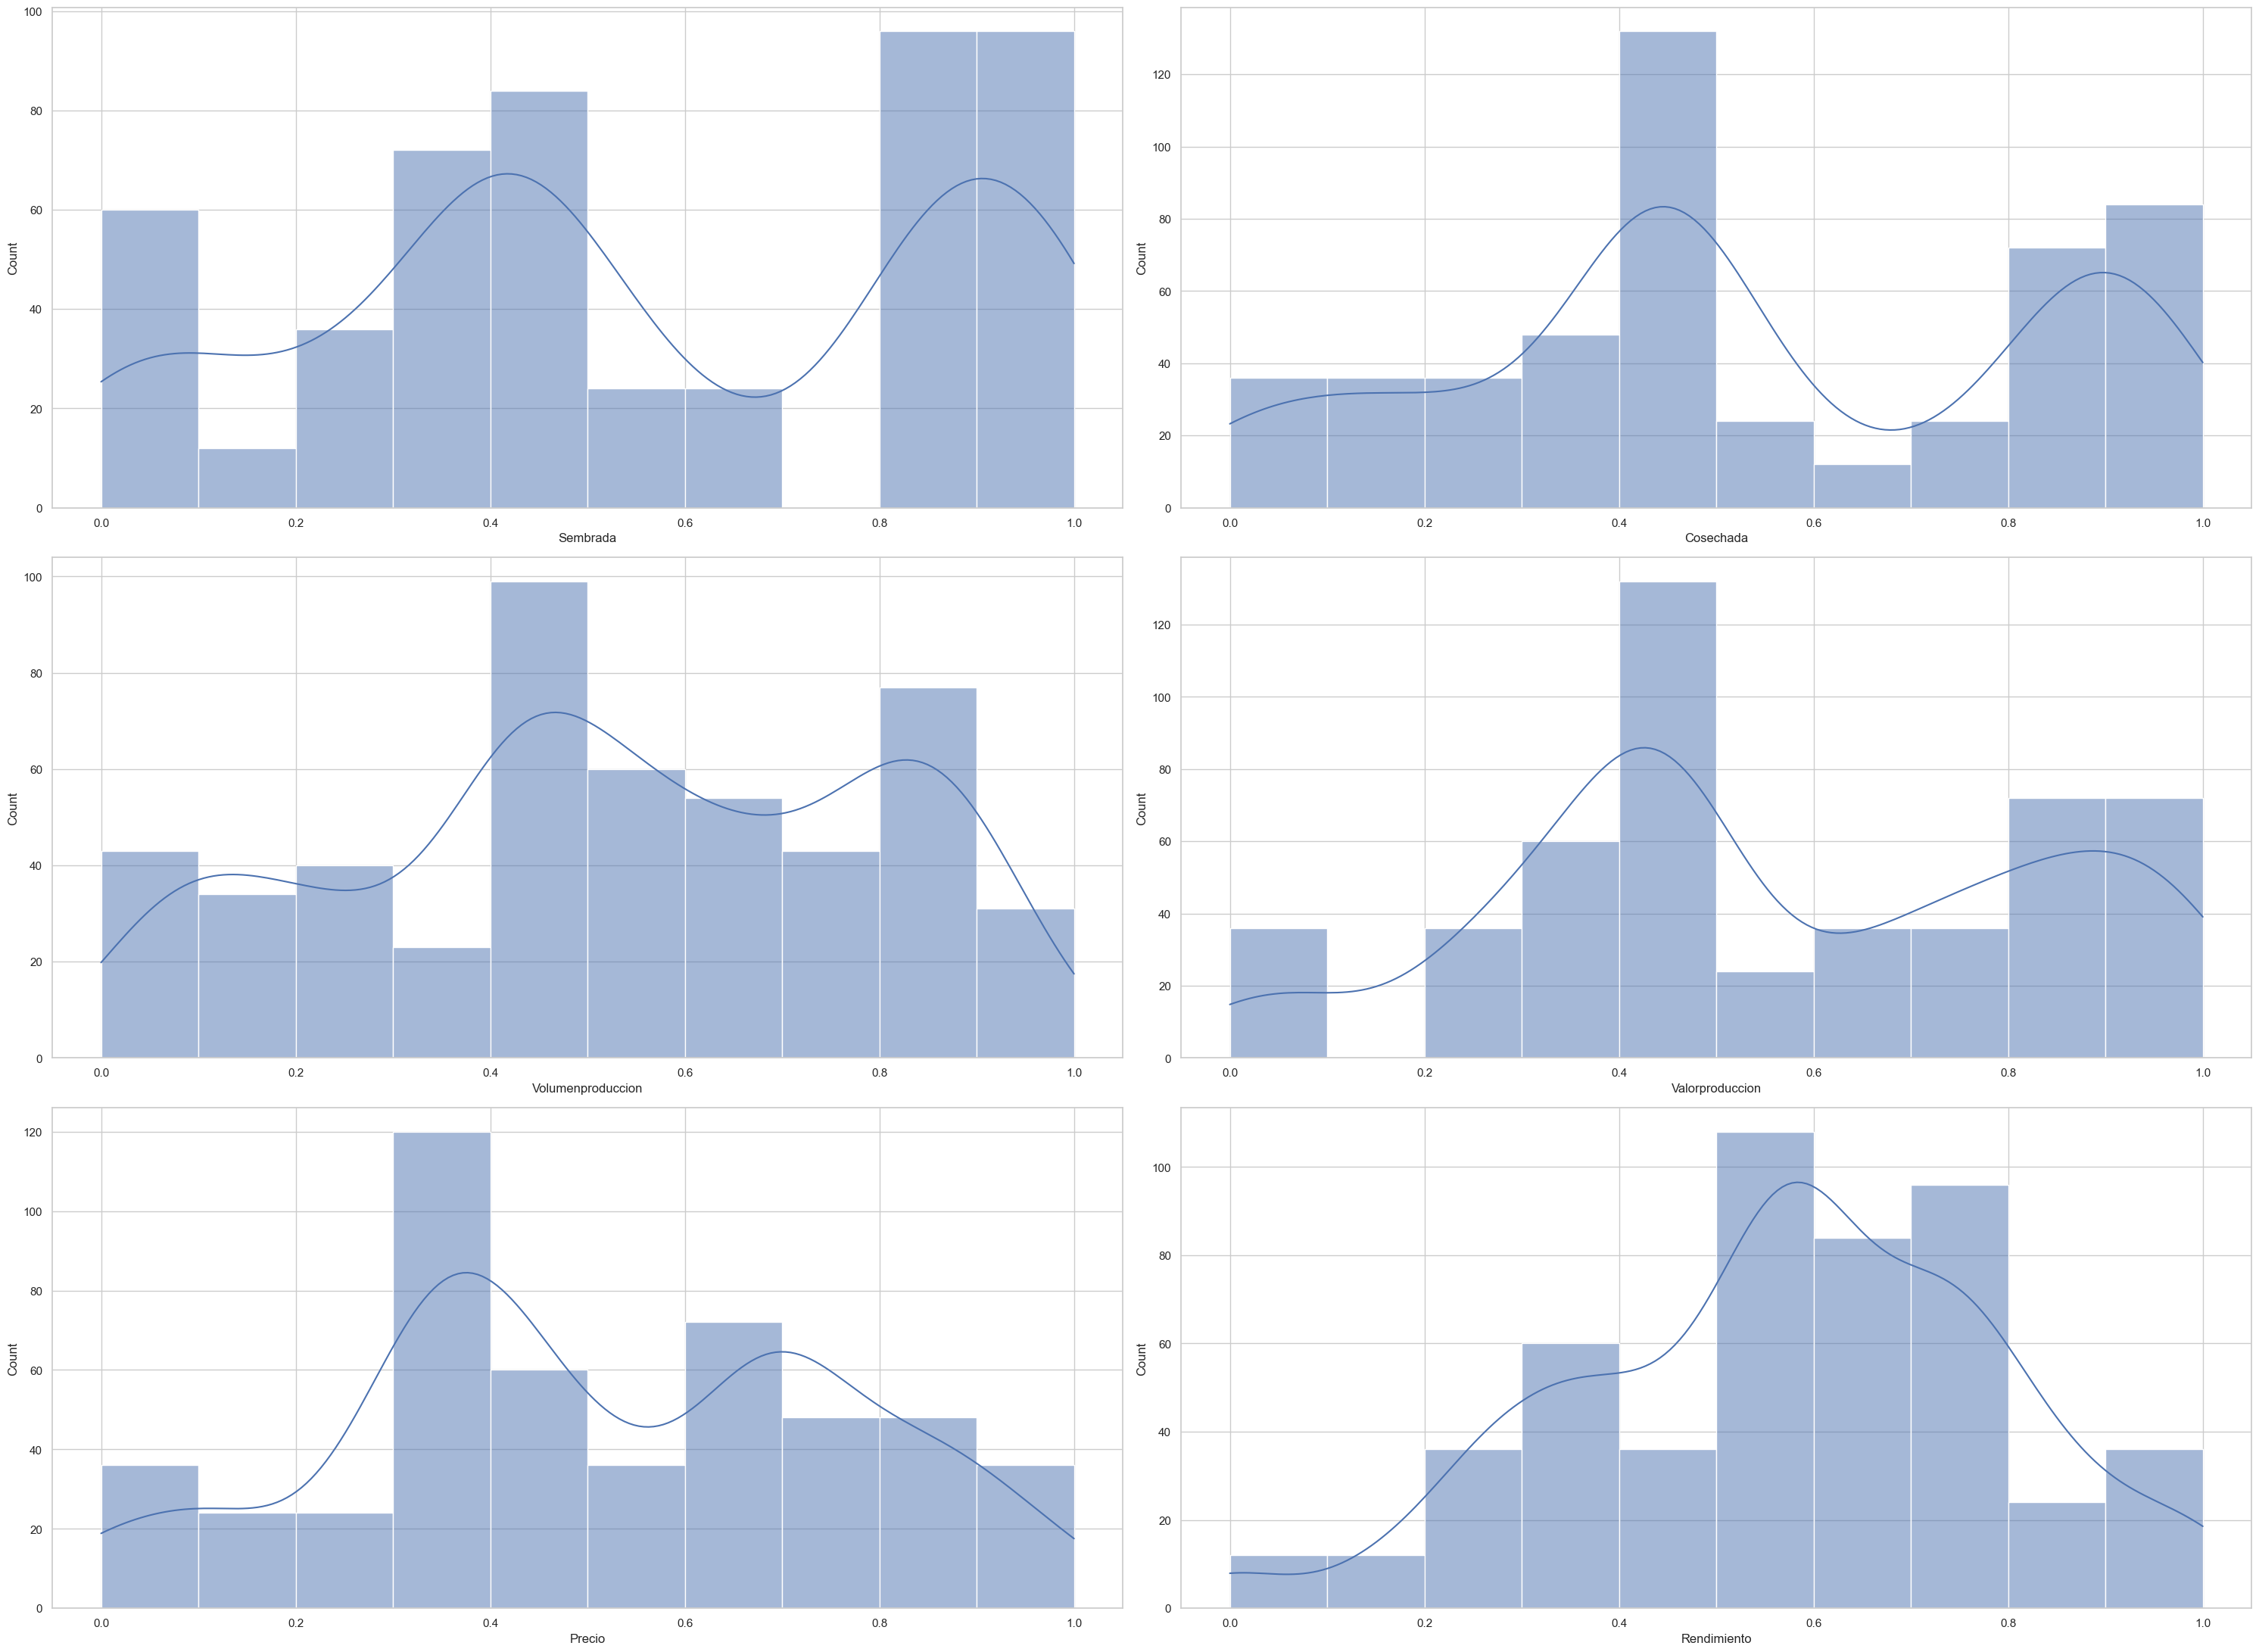

In [91]:
fig, axes = plt.subplots(3, 2, figsize=(30, 22))
# Histogramas de varaibles nméricas con transformación y normalización
for col, ax in zip(num_var, axes.ravel()):
    sns.histplot(df_scaled[col], bins=10, kde=True, ax=ax)
plt.tight_layout()
plt.show()

En los histogramas se puede observar como quedaron los rangos de las variables numéricas de 0 a 1, por lo que podrán emplearse en etapas futuras del modelado dependiendo del tipo de modelo que se pretenda utilizar.

*¿Hay desequilibrio en las clases de la variable objetivo?*

Para el dataset y el tipo de solución que se planea ejecutar, no se requiere detectar desequilibrio en las clases de la variable objetivo, ya que `Volumenproduccion` es una variable numérica continua. Por lo tanto, el enfoque del modelo corresponde a un problema de regresión y no de clasificación.

## <a class="anchor" id="conclusiones">Conclusiones</a>

A manera de conclusión, este análisis exploratorio de datos sirvió para responder preguntas clave que nos permitieron conocer y preprocesar nuestro conjunto de datos. Primeramente, este análisis demostró que no hay valores faltantes en nuestro dataset, ahorrándonos tiempo en imputar datos o eliminar registros inválidos. Por medio del análisis de las estadísticas resumidas del conjunto de datos se pudo detectar un problema en una columna, contenía únicamente ceros, por lo que se procedió a eliminarla por no aportar información valiosa al dataset. Igualmente, se identificó que la mayoría de las columnas numéricas contenían valores atípicos, por lo que se procedió a removerlos, y aunque al final la mayoría seguía teniendo outliers, estos ya no estaban tan alejados de los límites superiores. En cuanto a la cardinalidad de las variables, únicamente se cuenta con una variable categórica, y esta variable demostró tener una cardinalidad baja, solo tiene 2 tipos de respuesta, volviéndola una variable sencilla de trabajar para posteriormente construir un modelo. De la misma forma, también se identificó que la mayoría de las variables presentan asimetría positiva en la distribución de sus datos, por lo que a estas variables se les aplicó la transformación Box-Cox y se pudo comprobar que ahora su distribución es Gaussiana.

Por otro lado, dentro del dataset se identificó la presencia de una variable de tiempo `Anio`, la cual, en conjunto con las demás variables numéricas se analizó su comportamiento a lo largo del tiempo, en donde se observaron incrementos constantes conforme avanzan los años, así como diferencias entre las modalidades Riego y Temporal. En cuanto a la relación entre variables, se encontró que la correlación más alta y positiva fue entre `Cosechada` y `Volumenproduccion`, seguida de `Sembrada` y `Volumenproduccion`, lo que indica una fuerte relación entre lo trabajado y el volumen final obtenido. Respecto a la normalización, se concluyó que es aplicable dependiendo del modelo que se utilice. Para modelos de series de tiempo no es obligatorio, sin embargo, para modelos de redes neuronales sí es recomendable. Por esta razón, se aplicó una normalización de tipo MinMax sobre las variables numéricas, llevando los valores a un rango entre 0 y 1 sin alterar la forma de su distribución.  Finalmente, no fue necesario evaluar desequilibrio de clases en la variable objetivo, ya que `Volumenproduccion` es una variable numérica continua. Por lo tanto, el enfoque del problema corresponde a regresión y no a clasificación donde sí tendría sentido aplicar técnicas de balanceo de clases.

Con el análisis elaborado, se obtuvieron las siguientes observaciones clave, las variables `Sembrada`, `Cosechada` y `Volumenproduccion` cuentan con una correlación, por lo que serán altamente consideradas para la generación del modelo. Otro aspecto que se notó fue que las modalidades dentro de la variable `Nommodalidad` cuentan con patrones muy específicos, que se deberán considerar para ver su impacto en el volumen de producción. Mientras que los valores atípicos podrían ser reflejos de fenómenos que se han presentado a lo largo de los años y que se podrían identificar al hacer investigaciones más profundas. Por último, se observan aumentos en la mayoría de las variables, lo cual refleja que claramente las tendencias a lo largo del tiempo son clave para el modelo.

## <a class="anchor" id="ref">Referencias</a>

[<a class="anchor" id="ref1">1</a>] Secretaría de Agricultura y Desarrollo Rural, “Cierre agrícola,” *AGRICULTURA*, s.f. [En línea].
Disponible en: https://nube.agricultura.gob.mx/cierre_agricola/. Accedido: 26-ene.-2026.

[<a class="anchor" id="ref2">2</a>] Secretaría de Agricultura y Desarrollo Rural, “Datos abiertos del sector agrícola,” *AGRICULTURA*, s.f.
[En línea]. Disponible en: https://nube.agricultura.gob.mx/datosAbiertos/Agricola.php. Accedido: 26-
ene.-2026.

[<a class="anchor" id="ref3">3</a>] United States International Trade Commission (USITC), “DataWeb: Importaciones generales por HTS,” *USITC*, s. f. [En línea]. Disponible en: https://dataweb.usitc.gov/trade/search/GenImp/HTS. Accedido: 28-ene.-2026.